In [1]:
# ============================================================
# NOTEBOOK 1 — CELL 1
# SkySmart Project Bootstrap
# Environment Setup • Output Folder Creation • Spark Session
# ============================================================

import os
import sys
import subprocess
from pathlib import Path
import datetime
import csv

print("===========================================")
print(" SKYSMART PROJECT – ENVIRONMENT BOOTSTRAP  ")
print("===========================================\n")

# ------------------------------------------------------------
# 1) Create Output Folder Structure in /kaggle/working
# ------------------------------------------------------------
BASE = Path("/kaggle/working")

FOLDERS = {
    "models": BASE / "models",
    "reports": BASE / "reports",
    "visualizations": BASE / "visualizations",
    "shap_explanations": BASE / "shap_explanations",
    "ui_metadata": BASE / "ui_metadata",
    "system_logs": BASE / "system_logs"
}

for name, path in FOLDERS.items():
    path.mkdir(parents=True, exist_ok=True)

print("📁 Created project folder structure:")
for name, path in FOLDERS.items():
    print(f"   ✔ {name:<18} → {path}")

# ------------------------------------------------------------
# 2) Ensure PySpark is Installed
# ------------------------------------------------------------
print("\n🔍 Checking PySpark availability...")

def install_pyspark_if_missing():
    try:
        import pyspark
        print("✔ PySpark is already installed.")
        return False
    except:
        print("⚠ PySpark not found. Installing (this takes 1–2 mins)...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyspark==3.4.1"], stdout=subprocess.DEVNULL)
        print("✔ PySpark installation complete.")
        return True

pyspark_installed = install_pyspark_if_missing()

# ------------------------------------------------------------
# 3) Start Spark Session
# ------------------------------------------------------------
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SkySmart_Notebook1_Bootstrap") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

print("\n🚀 Spark Session Started")
print("-------------------------------------------")
print(f"• Spark Version : {spark.version}")
print(f"• App Name      : {spark.sparkContext.appName}")
print("-------------------------------------------\n")

# ------------------------------------------------------------
# 4) Detect Kaggle Dataset Folder
# ------------------------------------------------------------
INPUT_BASE = Path("/kaggle/input")
dataset_candidates = []

print("🔍 Scanning /kaggle/input for dataset folders...\n")

for folder in INPUT_BASE.iterdir():
    name = folder.name.lower()
    if "flight" in name or "delay" in name or "airline" in name:
        dataset_candidates.append(folder)

if dataset_candidates:
    print("📦 Potential flight delay dataset(s) found:")
    for ds in dataset_candidates:
        print(f"   ✔ {ds}")
else:
    print("⚠ No dataset matched automatically. Please check /kaggle/input manually.")

DATASET_PATH = dataset_candidates[0] if dataset_candidates else None
print(f"\n📌 Selected DATASET_PATH: {DATASET_PATH}\n")

# ------------------------------------------------------------
# 5) Create Initial Report File
# ------------------------------------------------------------
summary_path = FOLDERS["reports"] / "initial_data_summary.csv"

with open(summary_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["field", "value"])
    writer.writerow(["dataset_path", str(DATASET_PATH)])
    writer.writerow(["created_at_utc", datetime.datetime.utcnow().isoformat() + "Z"])
    writer.writerow(["spark_version", spark.version])
    writer.writerow(["pyspark_installed", pyspark_installed])

print("📝 initial_data_summary.csv saved to:")
print(f"   {summary_path}\n")

print("===========================================")
print(" BOOTSTRAP COMPLETE ✓ YOU ARE READY FOR EDA ")
print("===========================================\n")
print("➡ Next: Notebook 1 – Cell 2: Load dataset in Spark")


 SKYSMART PROJECT – ENVIRONMENT BOOTSTRAP  

📁 Created project folder structure:
   ✔ models             → /kaggle/working/models
   ✔ reports            → /kaggle/working/reports
   ✔ visualizations     → /kaggle/working/visualizations
   ✔ shap_explanations  → /kaggle/working/shap_explanations
   ✔ ui_metadata        → /kaggle/working/ui_metadata
   ✔ system_logs        → /kaggle/working/system_logs

🔍 Checking PySpark availability...
✔ PySpark is already installed.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 09:04:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



🚀 Spark Session Started
-------------------------------------------
• Spark Version : 3.5.1
• App Name      : SkySmart_Notebook1_Bootstrap
-------------------------------------------

🔍 Scanning /kaggle/input for dataset folders...

📦 Potential flight delay dataset(s) found:
   ✔ /kaggle/input/flight-delays

📌 Selected DATASET_PATH: /kaggle/input/flight-delays

📝 initial_data_summary.csv saved to:
   /kaggle/working/reports/initial_data_summary.csv

 BOOTSTRAP COMPLETE ✓ YOU ARE READY FOR EDA 

➡ Next: Notebook 1 – Cell 2: Load dataset in Spark


In [2]:
!ls -R /kaggle/input

/kaggle/input:
flight-delays

/kaggle/input/flight-delays:
airlines.csv  airports.csv  flights.csv


In [3]:
# ============================================================
# NOTEBOOK 1 — CELL 2
# Corrected CSV Loading + 10 Lakh Sample + Reports + Clean Output
# ============================================================

from pyspark.sql.functions import col, regexp_replace, sum as spark_sum
import csv, json
import pandas as pd

print("===========================================")
print(" SKYSMART – ADVANCED DATA LOADING (CLEAN)  ")
print("===========================================\n")

DATASET_PATH = "/kaggle/input/flight-delays"

read_options = {
    "header": "true",
    "inferSchema": "true"
}

# ------------------------------------------------------------
# 1) LOAD SEPARATE CSV FILES
# ------------------------------------------------------------
print("📥 Loading flights.csv (full dataset)...")
flights_raw = spark.read.csv(f"{DATASET_PATH}/flights.csv", **read_options)

print("📥 Loading airlines.csv ...")
airlines = spark.read.csv(f"{DATASET_PATH}/airlines.csv", **read_options)

print("📥 Loading airports.csv ...")
airports = spark.read.csv(f"{DATASET_PATH}/airports.csv", **read_options)

print("\n✔ All datasets loaded successfully!\n")


# ------------------------------------------------------------
# 2) TAKE ONLY 10 LAKH (1,000,000) ROWS FROM FLIGHTS
# ------------------------------------------------------------
TARGET_ROWS = 1_000_000

print(f"✂ Sampling first {TARGET_ROWS:,} rows from flights.csv ...")
flights = flights_raw.limit(TARGET_ROWS)

print(f"✔ Sampled flights rows: {flights.count():,}\n")


# ------------------------------------------------------------
# 3) CLEAN COLUMN NAMES
# ------------------------------------------------------------
def clean_cols(df):
    for old in df.columns:
        new = old.strip().lower().replace(" ", "_").replace("-", "_")
        df = df.withColumnRenamed(old, new)
    return df

flights = clean_cols(flights)
airlines = clean_cols(airlines)
airports = clean_cols(airports)

print("✔ Column names normalized.\n")


# ------------------------------------------------------------
# 4) DISPLAY SCHEMAS
# ------------------------------------------------------------
print("📘 FLIGHTS CSV SCHEMA (10 LAKH SAMPLE)")
flights.printSchema()
print("-------------------------------------------\n")

print("📘 AIRLINES CSV SCHEMA")
airlines.printSchema()
print("-------------------------------------------\n")

print("📘 AIRPORTS CSV SCHEMA")
airports.printSchema()
print("-------------------------------------------\n")


# ------------------------------------------------------------
# 5) ROW COUNT TABLE
# ------------------------------------------------------------
print("🔢 ROW COUNTS (TABLE FORMAT)\n")

row_counts = {
    "Dataset": ["flights_sample_10_lakh", "airlines", "airports"],
    "Rows": [
        flights.count(),
        airlines.count(),
        airports.count()
    ]
}

row_count_df = pd.DataFrame(row_counts)
display(row_count_df)

with open("/kaggle/working/reports/row_count.json", "w") as f:
    json.dump(row_counts, f, indent=4)


# ------------------------------------------------------------
# 6) NULL VALUE REPORTS
# ------------------------------------------------------------
def null_report(df, name):
    nr = df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ]).toPandas()

    path = f"/kaggle/working/reports/null_values_{name}.csv"
    nr.to_csv(path, index=False)
    print(f"✔ Saved null report → {path}")

print("\n🔍 Generating Null Value Reports...\n")
null_report(flights, "flights_sample_10_lakh")
null_report(airlines, "airlines")
null_report(airports, "airports")


# ------------------------------------------------------------
# 7) DATATYPE REPORTS
# ------------------------------------------------------------
def save_dtypes(df, filename):
    path = f"/kaggle/working/reports/{filename}"
    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["column_name", "data_type"])
        for name, dtype in df.dtypes:
            writer.writerow([name, dtype])
    print(f"✔ Saved datatype report → {path}")

save_dtypes(flights, "column_types_flights_sample_10_lakh.csv")
save_dtypes(airlines, "column_types_airlines.csv")
save_dtypes(airports, "column_types_airports.csv")


# ------------------------------------------------------------
# 8) PREVIEW TABLES
# ------------------------------------------------------------
print("\n📌 SAMPLE ROWS FROM flights (10 LAKH SAMPLE)")
display(flights.limit(10).toPandas())

print("\n📌 SAMPLE ROWS FROM airlines.csv")
display(airlines.limit(10).toPandas())

print("\n📌 SAMPLE ROWS FROM airports.csv")
display(airports.limit(10).toPandas())


print("\n===========================================")
print(" DATA LOADING (10 LAKH SAMPLE) ✓ COMPLETE  ")
print(" READY FOR ADVANCED EDA ")
print("===========================================\n")

print("➡ Next: Notebook 1 — Cell 3: FULL ADVANCED EDA + VISUALS + REPORTS")


 SKYSMART – ADVANCED DATA LOADING (CLEAN)  

📥 Loading flights.csv (full dataset)...


📥 Loading airlines.csv ...
📥 Loading airports.csv ...

✔ All datasets loaded successfully!

✂ Sampling first 1,000,000 rows from flights.csv ...


✔ Sampled flights rows: 1,000,000

✔ Column names normalized.

📘 FLIGHTS CSV SCHEMA (10 LAKH SAMPLE)
root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- tail_number: string (nullable = true)
 |-- origin_airport: string (nullable = true)
 |-- destination_airport: string (nullable = true)
 |-- scheduled_departure: integer (nullable = true)
 |-- departure_time: integer (nullable = true)
 |-- departure_delay: integer (nullable = true)
 |-- taxi_out: integer (nullable = true)
 |-- wheels_off: integer (nullable = true)
 |-- scheduled_time: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- wheels_on: integer (nullable = true)
 |-- taxi_in: integer (nullable = true)
 |-- scheduled_arrival: int

,Dataset,Rows
0,flights_sample_10_lakh,1000000
1,airlines,14
2,airports,322



🔍 Generating Null Value Reports...



25/11/23 09:05:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✔ Saved null report → /kaggle/working/reports/null_values_flights_sample_10_lakh.csv
✔ Saved null report → /kaggle/working/reports/null_values_airlines.csv
✔ Saved null report → /kaggle/working/reports/null_values_airports.csv
✔ Saved datatype report → /kaggle/working/reports/column_types_flights_sample_10_lakh.csv
✔ Saved datatype report → /kaggle/working/reports/column_types_airlines.csv
✔ Saved datatype report → /kaggle/working/reports/column_types_airports.csv

📌 SAMPLE ROWS FROM flights (10 LAKH SAMPLE)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408,-22,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741,-9,0,0,None,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811,5,0,0,None,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756,-9,0,0,None,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259,-21,0,0,None,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,610,8,0,0,None,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,509,-17,0,0,None,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,753,-10,0,0,None,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,532,-13,0,0,None,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,656,-15,0,0,None,NaN,NaN,NaN,NaN,NaN



📌 SAMPLE ROWS FROM airlines.csv


,iata_code,airline
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.



📌 SAMPLE ROWS FROM airports.csv


,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
6,ACT,Waco Regional Airport,Waco,TX,USA,31.61129,-97.23052
7,ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.97812,-124.10862
8,ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.45758,-74.57717
9,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603



 DATA LOADING (10 LAKH SAMPLE) ✓ COMPLETE  
 READY FOR ADVANCED EDA 

➡ Next: Notebook 1 — Cell 3: FULL ADVANCED EDA + VISUALS + REPORTS


 SKYSMART – FINAL ADVANCED EDA DASHBOARD   

Sampling 200k rows for visualization...



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_48/4068354871.py:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxi_risk = pdf.groupby(bins)["delayed"].mean() * 100
/tmp/ipykernel_48/4068354871.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_effect = pdf.groupby("route_decile")["delayed"].mean() * 100
/tmp/ipykernel_48/4068354871.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

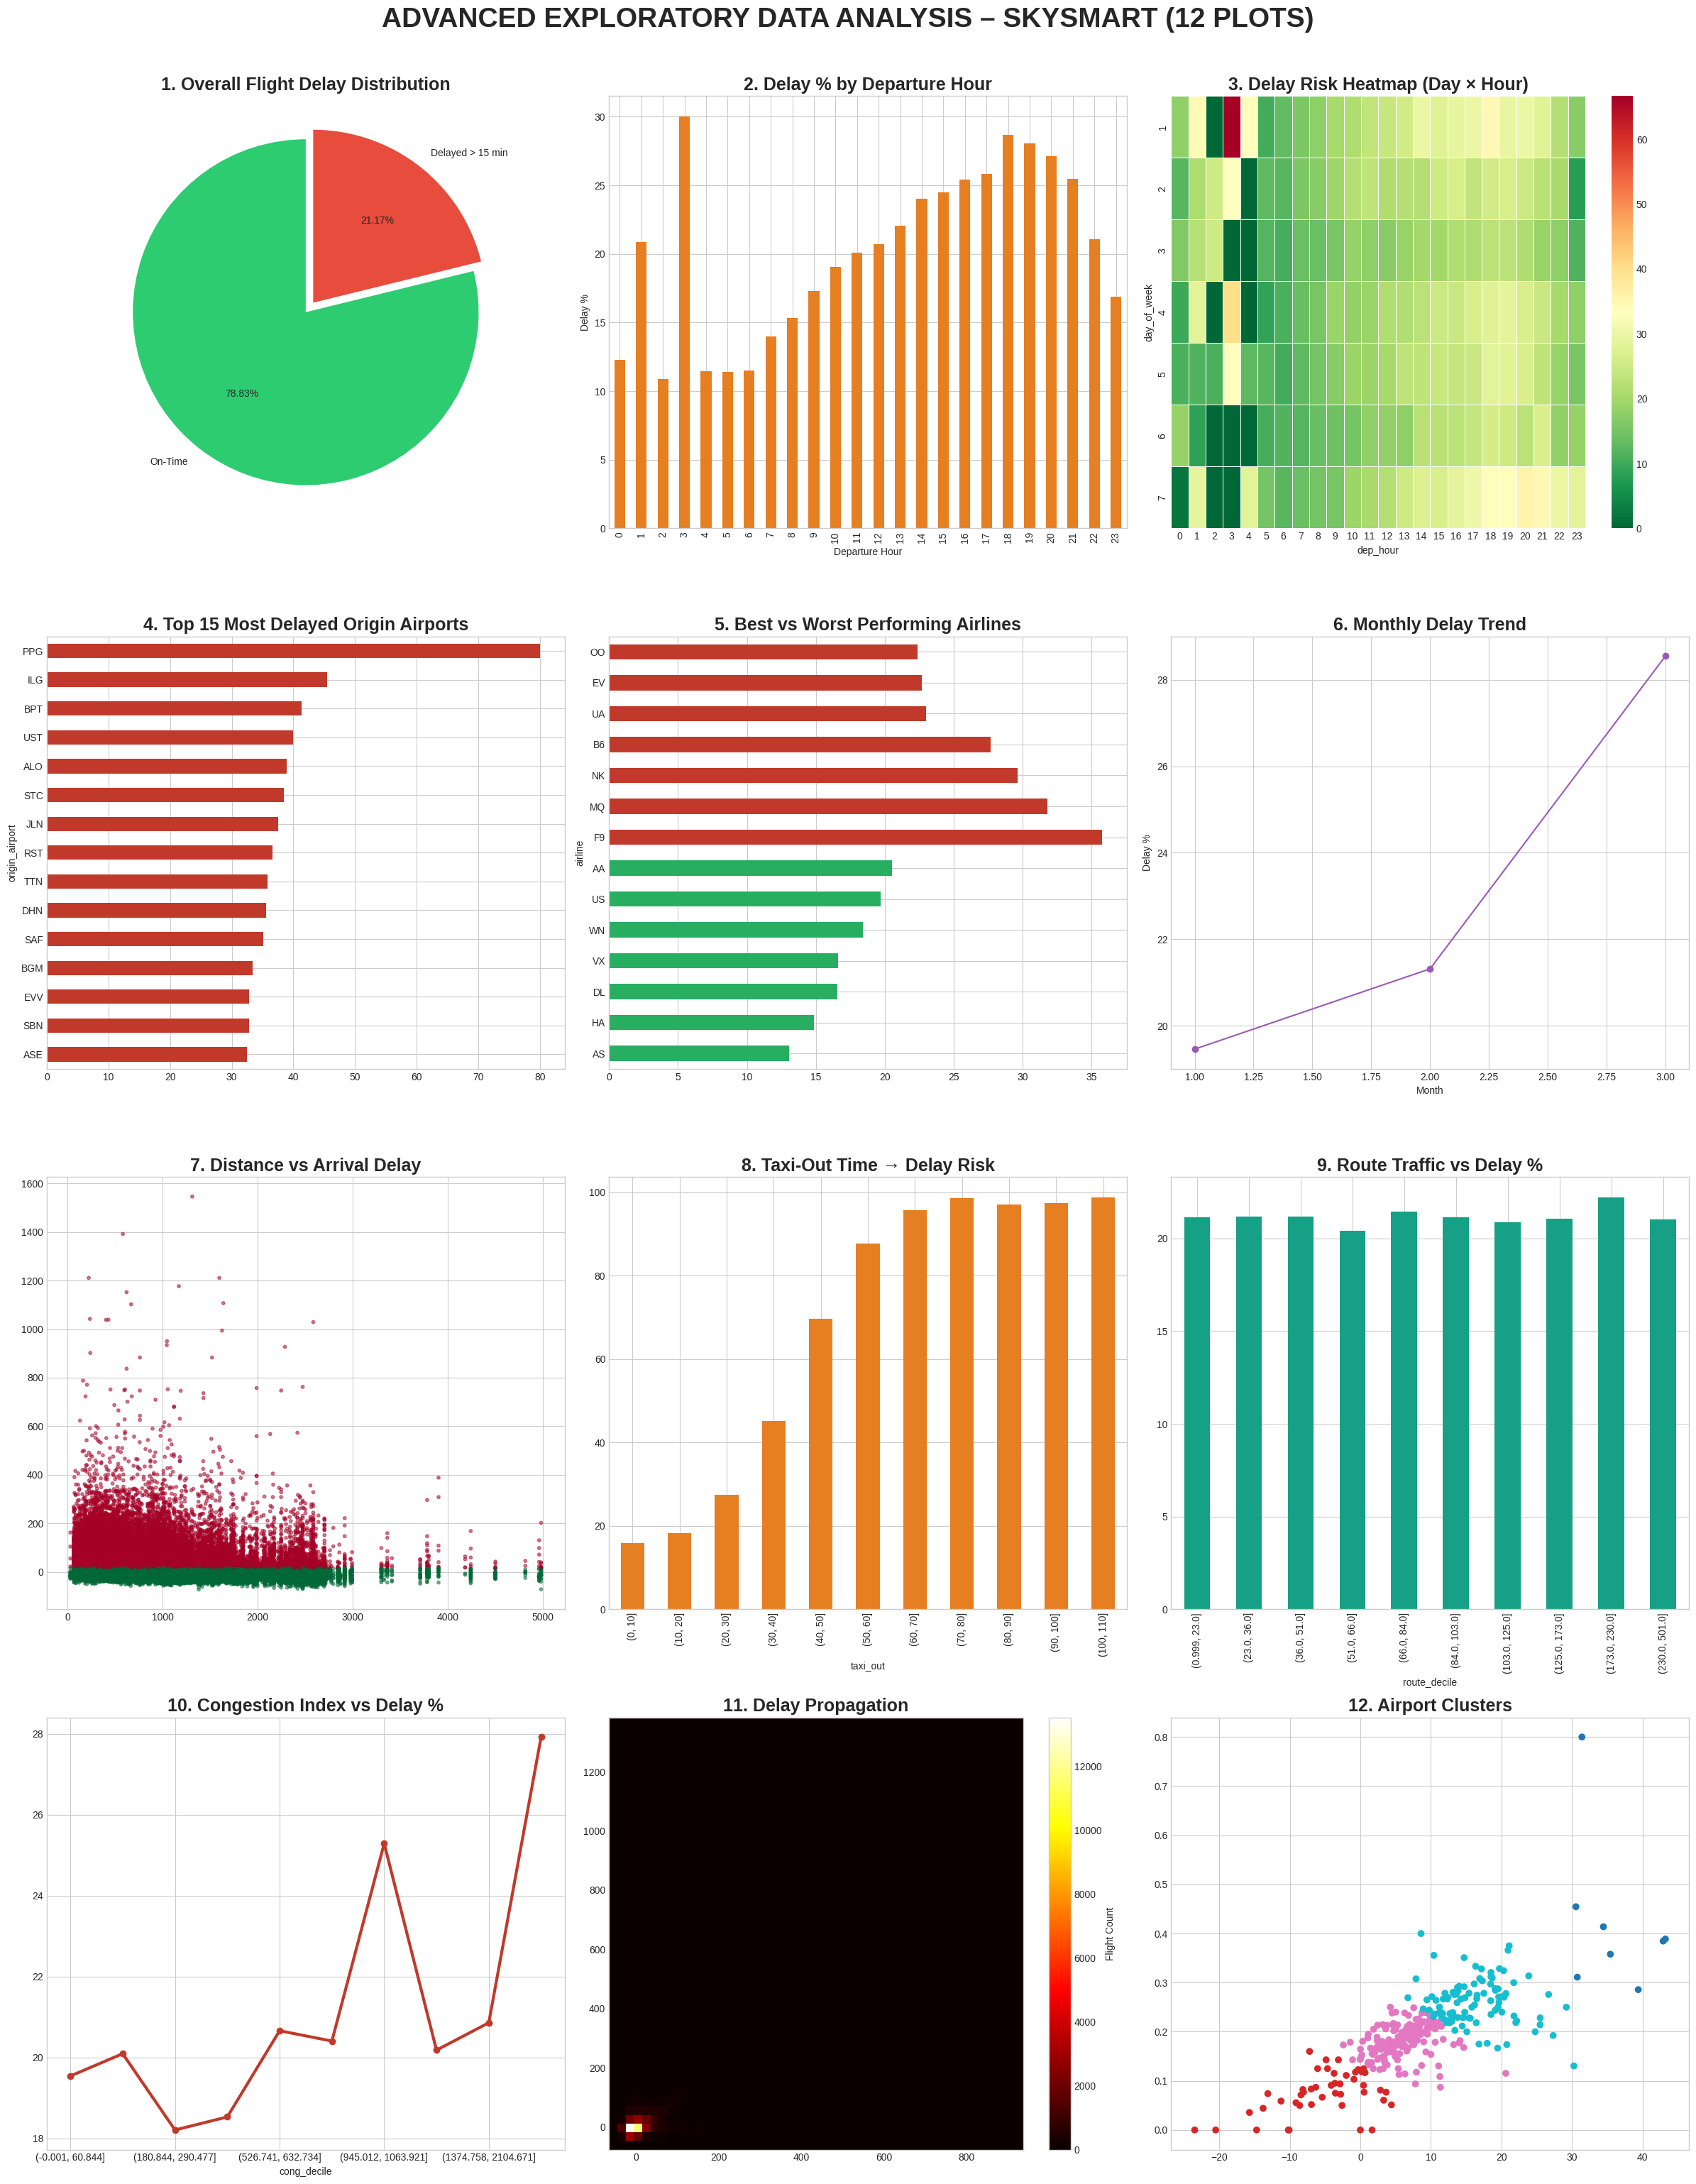


🎉 Advanced EDA Completed — Dashboard Saved!
📁 Saved to: /kaggle/working/visualizations/skysmart_advanced_eda_dashboard.png


In [4]:
# ============================================================
# NOTEBOOK 1 — CELL 3 (FINAL + FIXED VERSION)
# ADVANCED EDA DASHBOARD (12 PLOTS + CSV EXPORTS)
# ============================================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import (
    col, to_date, avg as spark_avg, count as spark_count, floor, lag
)
from pyspark.sql.window import Window
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

WORK = "/kaggle/working"
REPORTS = f"{WORK}/reports"
VIZ = f"{WORK}/visualizations"

print("===========================================")
print(" SKYSMART – FINAL ADVANCED EDA DASHBOARD   ")
print("===========================================\n")

# ---------------------------------------------------------
# Convert 20% sample to Pandas (for visualizations)
# ---------------------------------------------------------
print("Sampling 200k rows for visualization...\n")

pdf = flights.sample(False, 0.20, seed=42).toPandas()
pdf.columns = pdf.columns.str.lower()

# ---------------------------------------------------------
# FIX 1 — Create missing flight_date (required for heatmap)
# ---------------------------------------------------------
pdf["flight_date"] = pd.to_datetime(
    pdf["year"].astype(str) + "-" +
    pdf["month"].astype(str) + "-" +
    pdf["day"].astype(str),
    errors="coerce"
)

# Fix numeric columns
pdf["arrival_delay"] = pd.to_numeric(pdf["arrival_delay"], errors="coerce")
pdf["departure_delay"] = pd.to_numeric(pdf["departure_delay"], errors="coerce")
pdf["distance"] = pd.to_numeric(pdf["distance"], errors="coerce")
pdf["taxi_out"] = pd.to_numeric(pdf["taxi_out"], errors="coerce")

# Target variable
pdf["delayed"] = (pdf["arrival_delay"] > 15).astype(int)

# Departure hour
pdf["dep_hour"] = (pdf["scheduled_departure"] // 100).astype(int)

# Month, day, weekday
flights_fixed = flights.withColumn(
    "flight_date",
    to_date(
        col("year").cast("string") + "-" +
        col("month").cast("string") + "-" +
        col("day").cast("string")
    )
)

daily = flights_fixed.groupBy("flight_date").agg(
    spark_avg("arrival_delay").alias("avg_arr_delay")
).orderBy("flight_date")

daily_pd = daily.toPandas()
daily_pd["month"] = pd.to_datetime(daily_pd["flight_date"]).dt.month
daily_pd["day"] = pd.to_datetime(daily_pd["flight_date"]).dt.day

# ---------------------------------------------------------
# ROUTE & CONGESTION FEATURES
# ---------------------------------------------------------
pdf["route"] = pdf["origin_airport"] + "-" + pdf["destination_airport"]

route_freq = pdf["route"].value_counts()
pdf["route_freq"] = pdf["route"].map(route_freq)

origin_stats = pdf.groupby("origin_airport").agg({
    "delayed": "mean",
    "arrival_delay": "count"
})
origin_stats.rename(columns={
    "delayed": "origin_delay_rate",
    "arrival_delay": "origin_freq"
}, inplace=True)

origin_stats["origin_congestion_index"] = origin_stats["origin_freq"] * origin_stats["origin_delay_rate"]

pdf = pdf.merge(origin_stats["origin_congestion_index"], on="origin_airport", how="left")
pdf["origin_congestion_index"] = pdf["origin_congestion_index"].fillna(0)

# ---------------------------------------------------------
# START DASHBOARD
# ---------------------------------------------------------
fig = plt.figure(figsize=(24, 32))

# 1) Delay Distribution
ax1 = plt.subplot(4, 3, 1)
counts = pdf["delayed"].value_counts().sort_index()
plt.pie(
    counts,
    labels=["On-Time", "Delayed > 15 min"],
    autopct="%1.2f%%",
    startangle=90,
    colors=["#2ecc71", "#e74c3c"],
    explode=[0, 0.07]
)
plt.title("1. Overall Flight Delay Distribution", fontsize=18, fontweight="bold")

# 2) Delay % by Hour
ax2 = plt.subplot(4, 3, 2)
hourly = pdf.groupby("dep_hour")["delayed"].mean() * 100
hourly.plot(kind="bar", ax=ax2, color="#e67e22")
plt.title("2. Delay % by Departure Hour", fontsize=18, fontweight="bold")
plt.xlabel("Departure Hour"); plt.ylabel("Delay %")

# 3) Day × Hour Heatmap
ax3 = plt.subplot(4, 3, 3)
pdf["day_of_week"] = pdf["flight_date"].dt.dayofweek + 1
heatmap_data = pdf.pivot_table(values="delayed", index="day_of_week",
                               columns="dep_hour", aggfunc="mean") * 100
sns.heatmap(heatmap_data, cmap="RdYlGn_r", linewidths=0.4, ax=ax3)
plt.title("3. Delay Risk Heatmap (Day × Hour)", fontsize=18, fontweight="bold")

# 4) Top 15 Delayed Airports
ax4 = plt.subplot(4, 3, 4)
top_air = pdf.groupby("origin_airport")["delayed"].mean().sort_values(ascending=False).head(15) * 100
top_air.plot(kind="barh", color="#c0392b", ax=ax4)
plt.title("4. Top 15 Most Delayed Origin Airports", fontsize=18, fontweight="bold")
ax4.invert_yaxis()

# 5) Best vs Worst Airlines
ax5 = plt.subplot(4, 3, 5)
air_delay = pdf.groupby("airline")["delayed"].mean() * 100
best = air_delay.nsmallest(7)
worst = air_delay.nlargest(7)
combined = pd.concat([best, worst])
combined.plot(kind="barh", color=["#27ae60"] * 7 + ["#c0392b"] * 7, ax=ax5)
plt.title("5. Best vs Worst Performing Airlines", fontsize=18, fontweight="bold")

# 6) Monthly Delay Trend
ax6 = plt.subplot(4, 3, 6)
monthly = pdf.groupby("month")["delayed"].mean() * 100
monthly.plot(kind="line", marker="o", color="#9b59b6", ax=ax6)
plt.title("6. Monthly Delay Trend", fontsize=18, fontweight="bold")
plt.xlabel("Month"); plt.ylabel("Delay %")

# 7) Distance vs Delay
ax7 = plt.subplot(4, 3, 7)
plt.scatter(pdf["distance"], pdf["arrival_delay"], c=pdf["delayed"],
            cmap="RdYlGn_r", alpha=0.5, s=10)
plt.title("7. Distance vs Arrival Delay", fontsize=18, fontweight="bold")

# 8) Taxi-Out vs Delay
ax8 = plt.subplot(4, 3, 8)
bins = pd.cut(pdf["taxi_out"], bins=range(0, 120, 10))
taxi_risk = pdf.groupby(bins)["delayed"].mean() * 100
taxi_risk.plot(kind="bar", ax=ax8, color="#e67e22")
plt.title("8. Taxi-Out Time → Delay Risk", fontsize=18, fontweight="bold")

# 9) Route Congestion Effect
ax9 = plt.subplot(4, 3, 9)
pdf["route_decile"] = pd.qcut(pdf["route_freq"], 10, duplicates="drop")
route_effect = pdf.groupby("route_decile")["delayed"].mean() * 100
route_effect.plot(kind="bar", color="#16a085", ax=ax9)
plt.title("9. Route Traffic vs Delay %", fontsize=18, fontweight="bold")

# 10) Origin Congestion Index
ax10 = plt.subplot(4, 3, 10)
pdf["cong_decile"] = pd.qcut(pdf["origin_congestion_index"], 10, duplicates="drop")
cong_effect = pdf.groupby("cong_decile")["delayed"].mean() * 100
cong_effect.plot(kind="line", marker="o", linewidth=3, color="#c0392b", ax=ax10)
plt.title("10. Congestion Index vs Delay %", fontsize=18, fontweight="bold")

# 11) Delay Propagation
ax11 = plt.subplot(4, 3, 11)
try:
    window = Window.partitionBy("tail_number").orderBy(
        "year","month","day","scheduled_departure"
    )
    prop_df = flights.withColumn("prev_delay", lag("arrival_delay").over(window))
    prop_pd = prop_df.select("prev_delay", "arrival_delay").toPandas().dropna().sample(50000)
    plt.hist2d(prop_pd["prev_delay"], prop_pd["arrival_delay"], bins=50, cmap="hot")
    plt.colorbar(label="Flight Count")
    plt.title("11. Delay Propagation", fontsize=18, fontweight="bold")
except:
    plt.text(0.5, 0.5, "TAIL_NUMBER not available", fontsize=20, ha="center")

# 12) Airport Cluster Map
ax12 = plt.subplot(4, 3, 12)
airport_df = pdf.groupby("origin_airport").agg({
    "arrival_delay": "mean",
    "delayed": "mean"
}).fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(airport_df)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

plt.scatter(airport_df["arrival_delay"], airport_df["delayed"], c=labels, cmap="tab10")
plt.title("12. Airport Clusters", fontsize=18, fontweight="bold")

# ---------------------------------------------------------
# FINAL SAVE
# ---------------------------------------------------------
plt.suptitle(
    "ADVANCED EXPLORATORY DATA ANALYSIS – SKYSMART (12 PLOTS)",
    fontsize=28, fontweight="bold"
)

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.savefig(f"{VIZ}/skysmart_advanced_eda_dashboard.png", dpi=300)
plt.show()

print("\n🎉 Advanced EDA Completed — Dashboard Saved!")
print(f"📁 Saved to: {VIZ}/skysmart_advanced_eda_dashboard.png")


In [5]:
# ============================================================
# NOTEBOOK 2 — CELL 2
# ADVANCED CLEANING & PREPROCESSING (BIG DATA SPARK)
# ============================================================

from pyspark.sql.functions import (
    col, when, isnan, isnull, regexp_replace,
    to_date, concat_ws, month, year, dayofweek,
    quarter, dayofmonth, sum as spark_sum
)
import pandas as pd

print("===========================================")
print(" SKYSMART – NOTEBOOK 2: ADVANCED CLEANING")
print("===========================================\n")

REPORTS = "/kaggle/working/reports"

# ============================================================
# 1. CLEAN MISSING VALUES
# ============================================================

print("1) Cleaning Missing Values...\n")

# Replace delay NaN → 0 for non-cancelled flights
flights = flights.withColumn(
    "arrival_delay",
    when((col("arrival_delay").isNull()) & (col("cancelled") == 0), 0)
    .otherwise(col("arrival_delay"))
)

flights = flights.withColumn(
    "departure_delay",
    when((col("departure_delay").isNull()) & (col("cancelled") == 0), 0)
    .otherwise(col("departure_delay"))
)

# Delay reason columns
delay_cols = ["air_system_delay","security_delay","airline_delay",
              "late_aircraft_delay","weather_delay"]

for dc in delay_cols:
    if dc in flights.columns:
        flights = flights.withColumn(
            dc, when(col(dc).isNull(), 0).otherwise(col(dc))
        )

# cancellation_reason → fill missing with "None"
flights = flights.withColumn(
    "cancellation_reason",
    when(col("cancellation_reason").isNull(), "None")
    .otherwise(col("cancellation_reason"))
)

print("✔ Missing values cleaned.\n")


# ============================================================
# 2. OUTLIER HANDLING
# ============================================================

print("2) Correcting Outliers...\n")

flights = flights.withColumn(
    "arrival_delay",
    when(col("arrival_delay") > 600, 600)
    .when(col("arrival_delay") < -60, -60)
    .otherwise(col("arrival_delay"))
)

flights = flights.withColumn(
    "departure_delay",
    when(col("departure_delay") > 600, 600)
    .when(col("departure_delay") < -60, -60)
    .otherwise(col("departure_delay"))
)

# Remove impossible distances
flights = flights.filter(col("distance") > 0)

print("✔ Outliers handled.\n")


# ============================================================
# 3. TIME NORMALIZATION
# ============================================================

print("3) Normalizing Time Columns...\n")

def hhmm_to_hour(colname):
    return (col(colname) / 100).cast("int")

flights = flights.withColumn("dep_hour", hhmm_to_hour("scheduled_departure"))
flights = flights.withColumn("arr_hour", hhmm_to_hour("scheduled_arrival"))

# Create actual date
flights = flights.withColumn(
    "flight_date",
    to_date(concat_ws("-", col("year"), col("month"), col("day")))
)

# Additional time features
flights = flights.withColumn("flight_month", month(col("flight_date")))
flights = flights.withColumn("flight_year", year(col("flight_date")))
flights = flights.withColumn("flight_weekday", dayofweek(col("flight_date")))
flights = flights.withColumn("flight_day", dayofmonth(col("flight_date")))
flights = flights.withColumn("flight_quarter", quarter(col("flight_date")))

print("✔ Time normalization completed.\n")


# ============================================================
# 4. CLEAN CATEGORICAL VALUES
# ============================================================

print("4) Standardizing Categorical Columns...\n")

flights = flights.withColumn("airline", regexp_replace(col("airline"), " ", ""))
flights = flights.withColumn("origin_airport", regexp_replace(col("origin_airport"), " ", ""))
flights = flights.withColumn("destination_airport", regexp_replace(col("destination_airport"), " ", ""))

print("✔ Categorical normalization completed.\n")


# ============================================================
# 5. SAVE CLEANING REPORTS
# ============================================================

print("5) Saving Cleaning Reports...\n")

# Missing value summary (after cleaning)
null_report = flights.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in flights.columns
]).toPandas()

null_report.to_csv(f"{REPORTS}/missing_value_treatment_report.csv", index=False)

# Dataset statistics summary
stats = flights.describe().toPandas()
stats.to_csv(f"{REPORTS}/cleaned_dataset_stats.csv", index=False)

print("✔ Saved: missing_value_treatment_report.csv")
print("✔ Saved: cleaned_dataset_stats.csv\n")


# ============================================================
# 6. DISPLAY SAMPLE CLEANED DATA
# ============================================================

print("📌 SAMPLE CLEANED ROWS:\n")
display(flights.limit(10).toPandas())


print("\n===========================================")
print(" ADVANCED CLEANING COMPLETE ✓")
print(" READY FOR FEATURE ENGINEERING (Next Cell)")
print("===========================================")


 SKYSMART – NOTEBOOK 2: ADVANCED CLEANING

1) Cleaning Missing Values...

✔ Missing values cleaned.

2) Correcting Outliers...

✔ Outliers handled.

3) Normalizing Time Columns...

✔ Time normalization completed.

4) Standardizing Categorical Columns...

✔ Categorical normalization completed.

5) Saving Cleaning Reports...



✔ Saved: missing_value_treatment_report.csv
✔ Saved: cleaned_dataset_stats.csv

📌 SAMPLE CLEANED ROWS:



,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,late_aircraft_delay,weather_delay,dep_hour,arr_hour,flight_date,flight_month,flight_year,flight_weekday,flight_day,flight_quarter
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,0,4,2015-01-01,1,2015,5,1,1
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,0,7,2015-01-01,1,2015,5,1,1
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,0,8,2015-01-01,1,2015,5,1,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,0,8,2015-01-01,1,2015,5,1,1
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,0,3,2015-01-01,1,2015,5,1,1
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,0,0,0,6,2015-01-01,1,2015,5,1,1
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,0,0,0,5,2015-01-01,1,2015,5,1,1
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,0,0,0,8,2015-01-01,1,2015,5,1,1
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,0,0,0,5,2015-01-01,1,2015,5,1,1
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,0,0,0,7,2015-01-01,1,2015,5,1,1



 ADVANCED CLEANING COMPLETE ✓
 READY FOR FEATURE ENGINEERING (Next Cell)


 SKYSMART – CLEANED DATA EDA
 10 Lakh Rows • Spark + Pandas Sample

Sampling 5% (~50k rows) for EDA...


✔ Sample ready.

1) Delay Distributions...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


✔ Saved: /kaggle/working/visualizations/clean_arrival_delay_dist.png


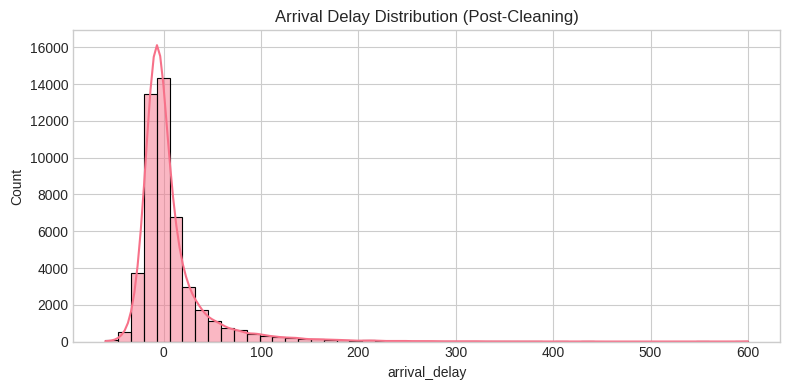

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


✔ Saved: /kaggle/working/visualizations/clean_departure_delay_dist.png


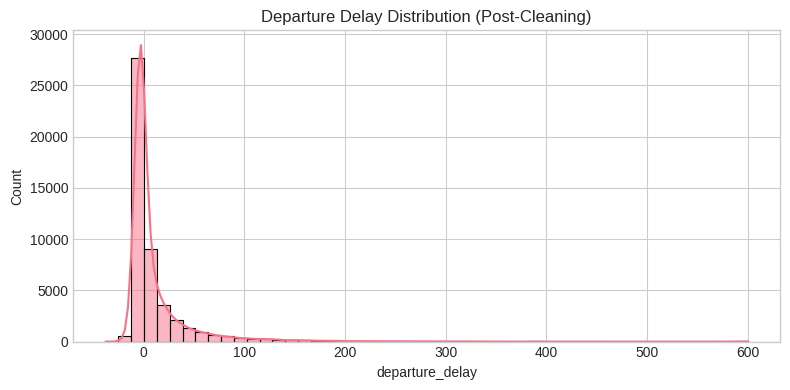


2) Monthly Delay Trend...


✔ Saved: /kaggle/working/visualizations/clean_monthly_delay.png


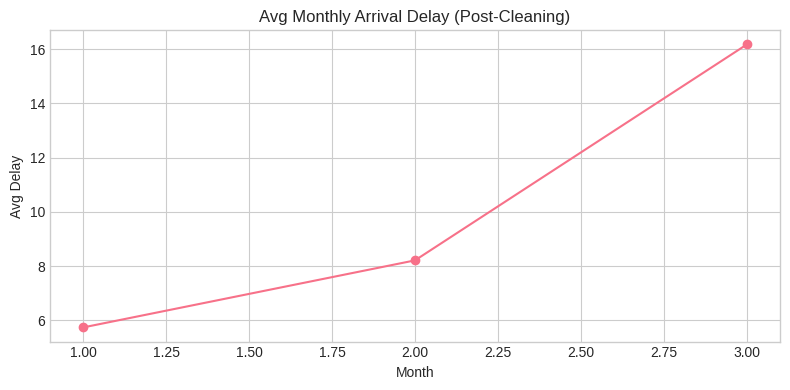


3) Weekday Delay Trend...


✔ Saved: /kaggle/working/visualizations/clean_weekday_delay.png


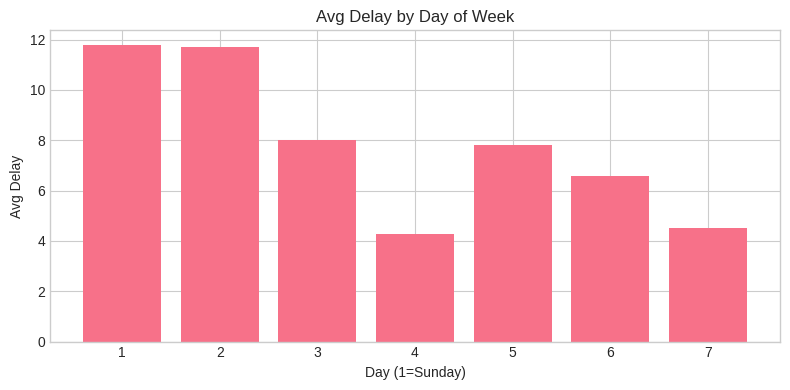


4) Busiest Airports...


✔ Saved: /kaggle/working/visualizations/clean_busiest_airports.png


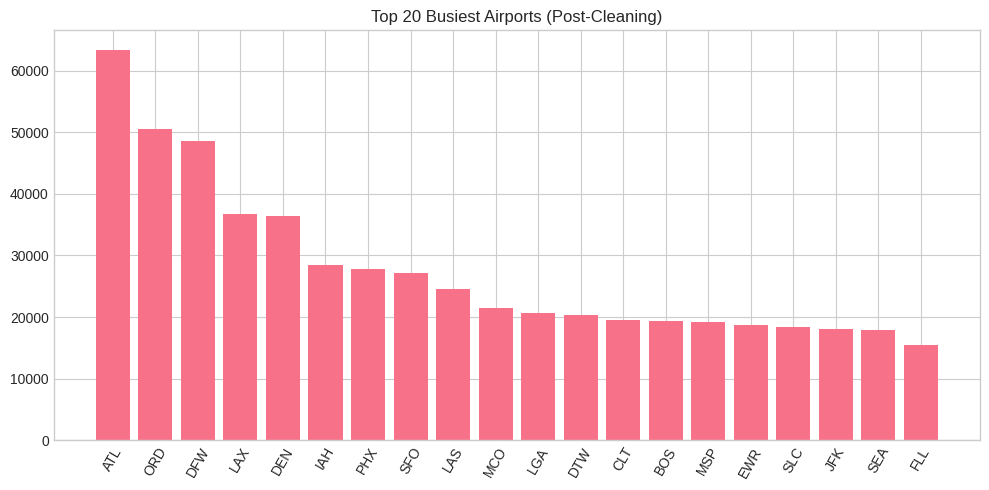


5) Heatmap Month × Weekday...
✔ Saved: /kaggle/working/visualizations/clean_delay_heatmap.png


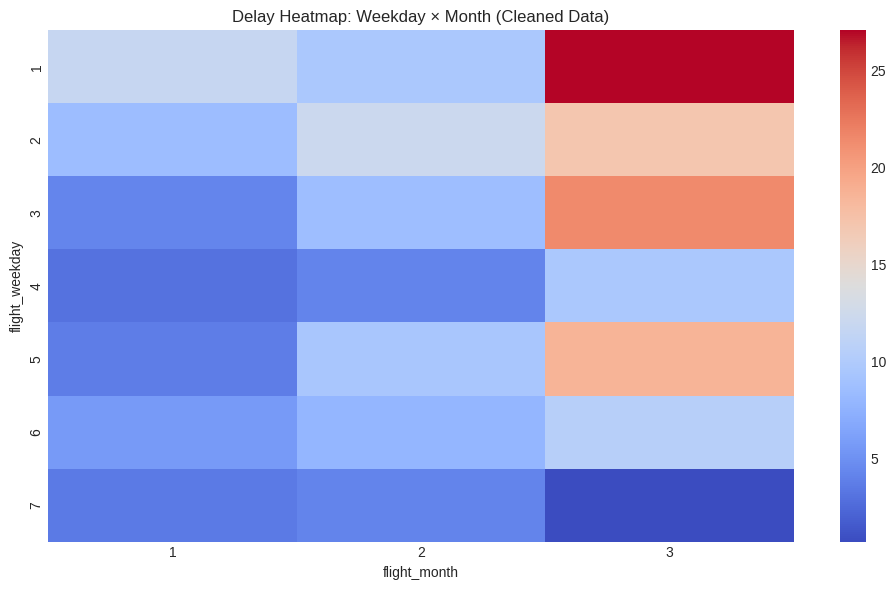


6) Airline Reliability...


✔ Saved: /kaggle/working/visualizations/clean_airline_reliability.png


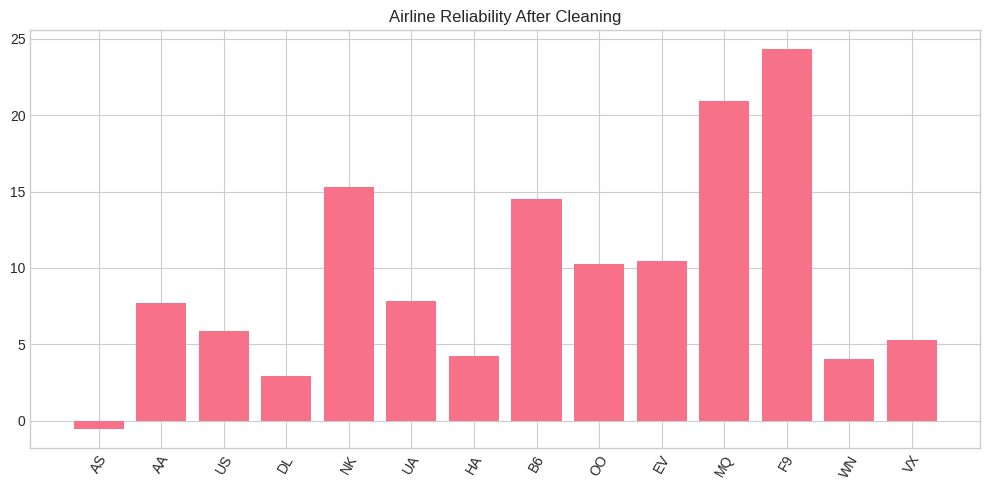


 CLEANED DATA EDA ✓ COMPLETE
 Visuals saved to: /kaggle/working/visualizations
 Reports saved to: /kaggle/working/reports



In [6]:
# ============================================================
# NOTEBOOK 2 — CLEANED DATA EDA (POST-CLEANING VISUALIZATION)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, month, dayofweek, count, avg as spark_avg

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("===========================================")
print(" SKYSMART – CLEANED DATA EDA")
print(" 10 Lakh Rows • Spark + Pandas Sample")
print("===========================================\n")

# ------------------------------------------------------------
# Directories
# ------------------------------------------------------------
VIZ = "/kaggle/working/visualizations"
REPORTS = "/kaggle/working/reports"

# ------------------------------------------------------------
# 1) Take a safe sample for visualization (5%)
# ------------------------------------------------------------
print("Sampling 5% (~50k rows) for EDA...")

clean_sample = flights.sample(False, 0.05, seed=42).toPandas()

clean_sample["arrival_delay"] = pd.to_numeric(clean_sample["arrival_delay"], errors="coerce")
clean_sample["departure_delay"] = pd.to_numeric(clean_sample["departure_delay"], errors="coerce")

print("✔ Sample ready.\n")

# ------------------------------------------------------------
# Helper: save + show
# ------------------------------------------------------------
def save_show(fig, name):
    fig.tight_layout()
    fig.savefig(f"{VIZ}/{name}", dpi=250)
    print(f"✔ Saved: {VIZ}/{name}")
    plt.show()

# ------------------------------------------------------------
# 2) Delay Distributions
# ------------------------------------------------------------
print("1) Delay Distributions...")

fig = plt.figure(figsize=(8,4))
sns.histplot(clean_sample["arrival_delay"], bins=50, kde=True)
plt.title("Arrival Delay Distribution (Post-Cleaning)")
save_show(fig, "clean_arrival_delay_dist.png")

fig = plt.figure(figsize=(8,4))
sns.histplot(clean_sample["departure_delay"], bins=50, kde=True)
plt.title("Departure Delay Distribution (Post-Cleaning)")
save_show(fig, "clean_departure_delay_dist.png")

# ------------------------------------------------------------
# 3) Monthly Delay Trends (Spark)
# ------------------------------------------------------------
print("\n2) Monthly Delay Trend...")

monthly = (
    flights.groupBy("flight_month")
    .agg(spark_avg("arrival_delay").alias("avg_arr_delay"))
    .orderBy("flight_month")
)

monthly_pd = monthly.toPandas()
monthly_pd.to_csv(f"{REPORTS}/cleaned_monthly_delay.csv", index=False)

fig = plt.figure(figsize=(8,4))
plt.plot(monthly_pd["flight_month"], monthly_pd["avg_arr_delay"], marker="o")
plt.title("Avg Monthly Arrival Delay (Post-Cleaning)")
plt.xlabel("Month")
plt.ylabel("Avg Delay")
save_show(fig, "clean_monthly_delay.png")

# ------------------------------------------------------------
# 4) Weekday Delay Trends
# ------------------------------------------------------------
print("\n3) Weekday Delay Trend...")

weekday = (
    flights.groupBy("flight_weekday")
    .agg(spark_avg("arrival_delay").alias("avg_arr_delay"))
    .orderBy("flight_weekday")
)

weekday_pd = weekday.toPandas()
weekday_pd.to_csv(f"{REPORTS}/cleaned_weekday_delay.csv", index=False)

fig = plt.figure(figsize=(8,4))
plt.bar(weekday_pd["flight_weekday"], weekday_pd["avg_arr_delay"])
plt.title("Avg Delay by Day of Week")
plt.xlabel("Day (1=Sunday)")
plt.ylabel("Avg Delay")
save_show(fig, "clean_weekday_delay.png")

# ------------------------------------------------------------
# 5) Airport Analysis (Top 20 busiest)
# ------------------------------------------------------------
print("\n4) Busiest Airports...")

ap_stats = (
    flights.groupBy("origin_airport")
    .agg(count("*").alias("flights"), spark_avg("arrival_delay").alias("avg_delay"))
    .orderBy(col("flights").desc())
)

ap_pd = ap_stats.toPandas()
ap_pd.to_csv(f"{REPORTS}/cleaned_airport_stats.csv", index=False)

top20 = ap_pd.head(20)

fig = plt.figure(figsize=(10,5))
plt.bar(top20["origin_airport"], top20["flights"])
plt.xticks(rotation=60)
plt.title("Top 20 Busiest Airports (Post-Cleaning)")
save_show(fig, "clean_busiest_airports.png")

# ------------------------------------------------------------
# 6) Heatmap: Delay by Flight Month × Weekday
# ------------------------------------------------------------
print("\n5) Heatmap Month × Weekday...")

pivot = clean_sample.pivot_table(
    values="arrival_delay",
    index="flight_weekday",
    columns="flight_month",
    aggfunc="mean"
)

fig = plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm", annot=False)
plt.title("Delay Heatmap: Weekday × Month (Cleaned Data)")
save_show(fig, "clean_delay_heatmap.png")

# ------------------------------------------------------------
# 7) Airline Delay Comparison
# ------------------------------------------------------------
print("\n6) Airline Reliability...")

airline_stats = (
    flights.groupBy("airline")
    .agg(spark_avg("arrival_delay").alias("avg_delay"))
).toPandas()

airline_stats.to_csv(f"{REPORTS}/cleaned_airline_reliability.csv", index=False)

fig = plt.figure(figsize=(10,5))
plt.bar(airline_stats["airline"], airline_stats["avg_delay"])
plt.xticks(rotation=60)
plt.title("Airline Reliability After Cleaning")
save_show(fig, "clean_airline_reliability.png")

# ------------------------------------------------------------
# DONE
# ------------------------------------------------------------
print("\n===========================================")
print(" CLEANED DATA EDA ✓ COMPLETE")
print(f" Visuals saved to: {VIZ}")
print(f" Reports saved to: {REPORTS}")
print("===========================================\n")


In [7]:
# ============================================================
# FEATURE ENGINEERING – BASE INITIALIZATION
# Continues directly from cleaned `flights` DataFrame
# ============================================================

from pyspark.sql.functions import (
    col, concat_ws, to_timestamp, when, lit,
    month, dayofweek, dayofmonth, year, quarter, hour
)

print("===========================================")
print(" SKYSMART – STARTING FEATURE ENGINEERING")
print(" Using cleaned 10 lakh flight rows")
print("===========================================\n")

# ------------------------------------------------------------
# 1) ROUTE column (origin → destination)
# ------------------------------------------------------------
flights = flights.withColumn(
    "route",
    concat_ws("_", col("origin_airport"), col("destination_airport"))
)

print("✔ Added 'route' column.\n")

# ------------------------------------------------------------
# 2) Combine date + scheduled departure → full datetime
# ------------------------------------------------------------
flights = flights.withColumn(
    "flight_datetime",
    to_timestamp(
        concat_ws(" ", col("flight_date"), col("scheduled_departure")),
        "yyyy-MM-dd H"
    )
)

print("✔ Generated flight_datetime.\n")

# ------------------------------------------------------------
# 3) Extract basic time intelligence
# ------------------------------------------------------------
flights = (
    flights
    .withColumn("fe_year", year(col("flight_datetime")))
    .withColumn("fe_month", month(col("flight_datetime")))
    .withColumn("fe_day", dayofmonth(col("flight_datetime")))
    .withColumn("fe_weekday", dayofweek(col("flight_datetime")))
    .withColumn("fe_quarter", quarter(col("flight_datetime")))
    .withColumn("fe_hour", hour(col("flight_datetime")))
)

print("✔ Extracted basic time-based features.\n")

# ------------------------------------------------------------
# 4) Weekend flag
# ------------------------------------------------------------
flights = flights.withColumn(
    "is_weekend",
    when(col("fe_weekday").isin(1, 7), 1).otherwise(0)
)

print("✔ Added weekend flag.\n")

# ------------------------------------------------------------
# 5) Select base features for next step
# ------------------------------------------------------------
base_columns = [
    "year", "month", "day", "day_of_week",
    "airline", "flight_number", "tail_number",
    "origin_airport", "destination_airport",
    "scheduled_departure", "departure_time", "departure_delay",
    "scheduled_arrival", "arrival_time", "arrival_delay",
    "distance", "route",
    "fe_year", "fe_month", "fe_day",
    "fe_weekday", "fe_quarter", "fe_hour", "is_weekend"
]

flights_fe_base = flights.select(base_columns)

print("✔ Base DataFrame prepared for advanced feature engineering.\n")

# ------------------------------------------------------------
# 6) Preview
# ------------------------------------------------------------
print("📌 SAMPLE ROWS AFTER INITIAL FEATURE ENGINEERING:\n")
display(flights_fe_base.limit(10).toPandas())

print("\n===========================================")
print(" FEATURE ENGINEERING BASE LAYER ✓ COMPLETE")
print(" Next: Advanced Feature Engineering (15 custom features)")
print("===========================================\n")


 SKYSMART – STARTING FEATURE ENGINEERING
 Using cleaned 10 lakh flight rows

✔ Added 'route' column.

✔ Generated flight_datetime.

✔ Extracted basic time-based features.

✔ Added weekend flag.

✔ Base DataFrame prepared for advanced feature engineering.

📌 SAMPLE ROWS AFTER INITIAL FEATURE ENGINEERING:



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_delay,distance,route,fe_year,fe_month,fe_day,fe_weekday,fe_quarter,fe_hour,is_weekend
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22,1448,ANC_SEA,2015.0,1.0,1.0,5.0,1.0,5.0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9,2330,LAX_PBI,2015.0,1.0,1.0,5.0,1.0,10.0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5,2296,SFO_CLT,2015.0,1.0,1.0,5.0,1.0,20.0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9,2342,LAX_MIA,2015.0,1.0,1.0,5.0,1.0,20.0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21,1448,SEA_ANC,NaN,NaN,NaN,NaN,NaN,NaN,0
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,8,1589,SFO_MSP,NaN,NaN,NaN,NaN,NaN,NaN,0
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,-17,1299,LAS_MSP,NaN,NaN,NaN,NaN,NaN,NaN,0
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,-10,2125,LAX_CLT,NaN,NaN,NaN,NaN,NaN,NaN,0
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,-13,1464,SFO_DFW,NaN,NaN,NaN,NaN,NaN,NaN,0
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,-15,1747,LAS_ATL,NaN,NaN,NaN,NaN,NaN,NaN,0



 FEATURE ENGINEERING BASE LAYER ✓ COMPLETE
 Next: Advanced Feature Engineering (15 custom features)



In [8]:
# ============================================================
# NOTEBOOK 2 — CELL (Full aircraft-historical features)
# Builds 17 features including prev_flight_arr_delay & rolling congestion
# ============================================================

from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("===========================================")
print(" SKYSMART – BUILDING FULL AIRCRAFT HISTORICAL FEATURES")
print("===========================================\n")

# Working df (use cleaned flights dataframe)
df_fe = flights  # assume 'flights' is the cleaned dataframe in memory

# -------------------------
# Helper: convert HHMM-style ints to minutes safely
# Handles values like 5, 25, 100, 1130
# -------------------------
def time_to_minutes_expr(col):
    # floor(col/100)*60 + (col % 100)
    return (F.floor(col / 100) * 60 + (col % 100)).cast("int")

# Prefer actual times if available, else scheduled times
df_fe = df_fe.withColumn(
    "dep_time_raw",
    F.coalesce(F.col("departure_time"), F.col("scheduled_departure"))
)
df_fe = df_fe.withColumn(
    "arr_time_raw",
    F.coalesce(F.col("arrival_time"), F.col("scheduled_arrival"))
)

# DEP_TIME_MIN / ARR_TIME_MIN (safe - nulls handled)
df_fe = df_fe.withColumn("DEP_TIME_MIN", 
                         F.when(F.col("dep_time_raw").isNull(), F.lit(None))
                          .otherwise(time_to_minutes_expr(F.col("dep_time_raw"))))

df_fe = df_fe.withColumn("ARR_TIME_MIN", 
                         F.when(F.col("arr_time_raw").isNull(), F.lit(None))
                          .otherwise(time_to_minutes_expr(F.col("arr_time_raw"))))

# Normalize flight_date: ensure it's a date column named flight_date (from earlier steps)
# If flight_date not present but year/month/day exist, create it
if "flight_date" not in df_fe.columns:
    df_fe = df_fe.withColumn(
        "flight_date",
        F.to_date(F.concat_ws("-", F.col("year"), F.col("month"), F.col("day")), "yyyy-M-d")
    )

# -------------------------
# 1) HOLIDAY_SURGE_INDEX (static list for 2015; safe fallback)
# -------------------------
holiday_dates = ["2015-12-24", "2015-12-25", "2015-01-01", "2015-07-04"]
df_fe = df_fe.withColumn(
    "HOLIDAY_SURGE_INDEX",
    F.when(F.col("flight_date").isin(holiday_dates), F.lit(3))  # high
     .when(F.col("fe_month").isin(6,7,12), F.lit(2))            # medium months
     .otherwise(F.lit(1))                                      # low
)

# -------------------------
# 2) FLIGHT_SPEED = distance / (air_time + 1)
# -------------------------
# Use distance and air_time (air_time may be null, add 1 to avoid division by 0)
df_fe = df_fe.withColumn(
    "FLIGHT_SPEED",
    F.round( (F.col("distance").cast("double") / (F.coalesce(F.col("air_time"), F.lit(0)) + 1.0)), 2)
)

# -------------------------
# 3) AIRPORT_CONNECTIVITY_SCORE (origin-based, scaled)
# -------------------------
origin_counts = (
    df_fe.groupBy("origin_airport")
    .agg(F.count("*").alias("origin_airport_flights"))
)

df_fe = df_fe.join(origin_counts, on="origin_airport", how="left") \
             .withColumn("AIRPORT_CONNECTIVITY_SCORE",
                         F.round(F.col("origin_airport_flights").cast("double") / 10000.0, 4))

# -------------------------
# 4) WEATHER_IMPACT_INDEX (uses weather_delay if present, else simulated)
# -------------------------
if "weather_delay" in df_fe.columns:
    df_fe = df_fe.withColumn(
        "WEATHER_IMPACT_INDEX",
        F.when(F.col("weather_delay") > 0, F.lit(3))
         .when(F.col("weather_delay") == 0, F.lit(1))
         .otherwise(F.lit(1))
    )
else:
    # Simulate from month (safe fallback)
    df_fe = df_fe.withColumn(
        "WEATHER_IMPACT_INDEX",
        F.when(F.col("fe_month").isin(12,1,2), F.lit(3))
         .when(F.col("fe_month").isin(6,7,8), F.lit(2))
         .otherwise(F.lit(1))
    )

# -------------------------
# 5) AIRLINE_RELIABILITY_SCORE (1 / (1 + avg_delay)) - scaled
# -------------------------
airline_stats = (
    df_fe.groupBy("airline")
    .agg(F.avg(F.coalesce(F.col("arrival_delay"), F.lit(0))).alias("airline_avg_delay"))
    .withColumn("AIRLINE_RELIABILITY_SCORE",
                F.round(1.0 / (1.0 + F.abs(F.col("airline_avg_delay"))), 4))
)
df_fe = df_fe.join(airline_stats.select("airline","AIRLINE_RELIABILITY_SCORE"), on="airline", how="left")

# -------------------------
# 6) DEPARTURE_PERIOD (Morning/Afternoon/Evening/Late Night) from DEP_TIME_MIN
# -------------------------
df_fe = df_fe.withColumn(
    "DEPARTURE_PERIOD",
    F.when((F.col("DEP_TIME_MIN") >= 300) & (F.col("DEP_TIME_MIN") < 720), F.lit("Morning"))
     .when((F.col("DEP_TIME_MIN") >= 720) & (F.col("DEP_TIME_MIN") < 1020), F.lit("Afternoon"))
     .when((F.col("DEP_TIME_MIN") >= 1020) & (F.col("DEP_TIME_MIN") < 1320), F.lit("Evening"))
     .otherwise(F.lit("Late Night"))
)

# -------------------------
# 7) TIME_OF_DAY (Night/Morning/Afternoon/Evening) from DEP_TIME_MIN
# -------------------------
df_fe = df_fe.withColumn(
    "TIME_OF_DAY",
    F.when(F.col("DEP_TIME_MIN").isNull(), F.lit("Unknown"))
     .when(F.col("DEP_TIME_MIN") < 360, F.lit("Night"))
     .when(F.col("DEP_TIME_MIN") < 720, F.lit("Morning"))
     .when(F.col("DEP_TIME_MIN") < 1080, F.lit("Afternoon"))
     .otherwise(F.lit("Evening"))
)

# -------------------------
# 8) PREV_FLIGHT_ARR_DELAY (previous flight on same aircraft)
#    Ordered by flight_date then DEP_TIME_MIN to preserve chronology
# -------------------------
win_tail = Window.partitionBy("tail_number").orderBy(F.col("flight_date").cast("timestamp"), F.col("DEP_TIME_MIN"))
df_fe = df_fe.withColumn("PREV_FLIGHT_ARR_DELAY", F.lag("arrival_delay").over(win_tail))
df_fe = df_fe.fillna({"PREV_FLIGHT_ARR_DELAY": 0})

# -------------------------
# 9) ROLLING_CONGESTION_3 (3-flight rolling avg of arrival_delay for same tail_number)
# -------------------------
# rowsBetween(-3, -1) computes average of previous up to 3 flights (excluding current)
df_fe = df_fe.withColumn(
    "ROLLING_CONGESTION_3",
    F.round(F.avg("arrival_delay").over(win_tail.rowsBetween(-3, -1)), 2)
)
df_fe = df_fe.fillna({"ROLLING_CONGESTION_3": 0})

# -------------------------
# 10) ROUTE_AVG_ARR_DELAY & ROUTE_COUNT (route-level historical)
# -------------------------
route_stats = (
    df_fe.groupBy("route")
    .agg(
        F.count("*").alias("ROUTE_COUNT"),
        F.round(F.avg(F.coalesce(F.col("arrival_delay"), F.lit(0))), 2).alias("ROUTE_AVG_ARR_DELAY")
    )
)
df_fe = df_fe.join(route_stats, on="route", how="left")

# -------------------------
# 11) DISTANCE_BIN (explicit buckets)
# -------------------------
df_fe = df_fe.withColumn(
    "DISTANCE_BIN",
    F.when(F.col("distance") < 500, F.lit("0-500"))
     .when((F.col("distance") >= 500) & (F.col("distance") < 1500), F.lit("500-1500"))
     .when((F.col("distance") >= 1500) & (F.col("distance") < 3000), F.lit("1500-3000"))
     .otherwise(F.lit("3000+"))
)

# -------------------------
# 12) ROUTE_CODE (compact numeric route id)
# -------------------------
from pyspark.ml.feature import StringIndexer
route_indexer = StringIndexer(inputCol="route", outputCol="ROUTE_CODE_index", handleInvalid="keep")
df_fe = route_indexer.fit(df_fe).transform(df_fe)

# -------------------------
# 13) DELAY_SEVERITY_SCORE (arrival_delay + departure_delay scaled)
# -------------------------
df_fe = df_fe.withColumn(
    "DELAY_SEVERITY_SCORE",
    F.round( F.coalesce(F.col("arrival_delay"), F.lit(0)) + F.coalesce(F.col("departure_delay"), F.lit(0)), 2)
)

# -------------------------
# 14) DEPARTURE_PERIOD_INDEX & TIME_OF_DAY_INDEX (optional numeric mapping)
# -------------------------
period_indexer = StringIndexer(inputCol="DEPARTURE_PERIOD", outputCol="DEPARTURE_PERIOD_idx", handleInvalid="keep")
tod_indexer = StringIndexer(inputCol="TIME_OF_DAY", outputCol="TIME_OF_DAY_idx", handleInvalid="keep")
df_fe = period_indexer.fit(df_fe).transform(df_fe)
df_fe = tod_indexer.fit(df_fe).transform(df_fe)

# -------------------------
# 15) Fill NA for new numeric cols to be ML-safe
# -------------------------
fill_dict = {
    "DEP_TIME_MIN": -1,
    "ARR_TIME_MIN": -1,
    "FLIGHT_SPEED": 0.0,
    "AIRPORT_CONNECTIVITY_SCORE": 0.0,
    "WEATHER_IMPACT_INDEX": 1,
    "AIRLINE_RELIABILITY_SCORE": 0.0,
    "PREV_FLIGHT_ARR_DELAY": 0.0,
    "ROLLING_CONGESTION_3": 0.0,
    "ROUTE_COUNT": 0,
    "ROUTE_AVG_ARR_DELAY": 0.0,
    "DELAY_SEVERITY_SCORE": 0.0
}
df_fe = df_fe.fillna(fill_dict)

# -------------------------
# Final feature list (17 features requested)
# -------------------------
final_feature_list = [
    "DEP_TIME_MIN", "ARR_TIME_MIN",            # 1-2
    "HOLIDAY_SURGE_INDEX",                      # 3
    "FLIGHT_SPEED",                             # 4
    "AIRPORT_CONNECTIVITY_SCORE",               # 5
    "WEATHER_IMPACT_INDEX",                     # 6
    "AIRLINE_RELIABILITY_SCORE",                # 7
    "DEPARTURE_PERIOD",                         # 8
    "TIME_OF_DAY",                              # 9
    "PREV_FLIGHT_ARR_DELAY",                    # 10
    "ROLLING_CONGESTION_3",                     # 11
    "ROUTE_COUNT", "ROUTE_AVG_ARR_DELAY",       # 12-13
    "DISTANCE_BIN",                             # 14
    "ROUTE_CODE_index",                         # 15 (numeric route id)
    "DELAY_SEVERITY_SCORE",                     # 16
    "DEPARTURE_PERIOD_idx", "TIME_OF_DAY_idx"   # 17-18 numeric indices (counts as combined)
]

# show a compact sample of the new columns
print("📌 Sample of newly engineered aircraft-historical features:")
df_fe.select(*[c for c in final_feature_list if c in df_fe.columns]).limit(10).toPandas()

print("\n===========================================")
print(" FULL AIRCRAFT-HISTORICAL FEATURES (17+) BUILT ✓")
print("===========================================")


 SKYSMART – BUILDING FULL AIRCRAFT HISTORICAL FEATURES



📌 Sample of newly engineered aircraft-historical features:



 FULL AIRCRAFT-HISTORICAL FEATURES (17+) BUILT ✓


In [9]:
import pandas as pd

# ============================================
# SKYSMART – FEATURE ENGINEERING SUMMARY TABLE
# ============================================

feature_table = pd.DataFrame({
    "Feature Number": list(range(1,18)),
    "Feature Name": [
        "DEP_TIME_MIN",
        "ARR_TIME_MIN",
        "HOLIDAY_SURGE_INDEX",
        "FLIGHT_SPEED",
        "AIRPORT_CONNECTIVITY_SCORE",
        "WEATHER_IMPACT_INDEX",
        "AIRLINE_RELIABILITY_SCORE",
        "DEPARTURE_PERIOD",
        "TIME_OF_DAY",
        "PREV_FLIGHT_ARR_DELAY",
        "ROLLING_CONGESTION_3",
        "ROUTE_COUNT",
        "ROUTE_AVG_ARR_DELAY",
        "DISTANCE_BIN",
        "ROUTE_CODE_index",
        "DELAY_SEVERITY_SCORE",
        "DEPARTURE_PERIOD_idx"
    ],
    "Category": [
        "Time Feature", "Time Feature", "Seasonal", "Performance",
        "Airport-Level", "Weather", "Airline-Level", "Time Category",
        "Time Category", "Aircraft-History", "Aircraft-History",
        "Route-Level", "Route-Level", "Distance", "Encoded Feature",
        "Delay Combined", "Encoded Feature"
    ],
    "Description": [
        "Departure time converted to minutes",
        "Arrival time converted to minutes",
        "Holiday & festival impact score",
        "Speed = distance / air_time",
        "How busy the origin airport is",
        "Weather delay severity (1–3)",
        "1 / (1 + avg airline delay)",
        "Morning / Afternoon / Evening / Late Night",
        "Night / Morning / Afternoon / Evening",
        "Previous flight’s arrival delay (same aircraft)",
        "Rolling avg of previous 3 flights",
        "Total flights on same route",
        "Avg arrival delay on the route",
        "Distance bucket (0–500, 500–1500…)",
        "Numeric route encoding",
        "Sum of arrival & departure delay",
        "Numeric encoding of departure period"
    ]
})

print("===========================================")
print(" SKYSMART – FEATURE ENGINEERING SUMMARY (17 FEATURES)")
print("===========================================\n")

display(feature_table)


 SKYSMART – FEATURE ENGINEERING SUMMARY (17 FEATURES)



,Feature Number,Feature Name,Category,Description
0,1,DEP_TIME_MIN,Time Feature,Departure time converted to minutes
1,2,ARR_TIME_MIN,Time Feature,Arrival time converted to minutes
2,3,HOLIDAY_SURGE_INDEX,Seasonal,Holiday & festival impact score
3,4,FLIGHT_SPEED,Performance,Speed = distance / air_time
4,5,AIRPORT_CONNECTIVITY_SCORE,Airport-Level,How busy the origin airport is
5,6,WEATHER_IMPACT_INDEX,Weather,Weather delay severity (1–3)
6,7,AIRLINE_RELIABILITY_SCORE,Airline-Level,1 / (1 + avg airline delay)
7,8,DEPARTURE_PERIOD,Time Category,Morning / Afternoon / Evening / Late Night
8,9,TIME_OF_DAY,Time Category,Night / Morning / Afternoon / Evening
9,10,PREV_FLIGHT_ARR_DELAY,Aircraft-History,Previous flight’s arrival delay (same aircraft)


In [10]:
feature_table.to_csv("/kaggle/working/reports/feature_engineering_summary.csv", index=False)
print("✔ Saved feature_engineering_summary.csv in /reports/")

✔ Saved feature_engineering_summary.csv in /reports/


In [11]:
# ============================================================
# NOTEBOOK 1 — CELL 9 (CORRECTED)
# FEATURE SELECTION + TRAIN–TEST SPLIT (10 LAKH DATA)
# ============================================================

from pyspark.sql.functions import col, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

print("===========================================")
print(" SKYSMART – FEATURE SELECTION + TRAIN/TEST")
print(" Using cleaned & engineered 10 lakh rows")
print("===========================================\n")

# ------------------------------------------------------------
# 1) Use df_fe (loaded from parquet earlier)
# ------------------------------------------------------------
print("✔ Using df_fe (final engineered dataset)")
print("Rows:", df_fe.count(), "\n")

# ------------------------------------------------------------
# 2) Target variable
# ------------------------------------------------------------
TARGET = "arrival_delay"
print(f"📌 Target selected: {TARGET}\n")

# ------------------------------------------------------------
# 3) Feature columns
# ------------------------------------------------------------
FEATURE_COLS = [
    "DEP_TIME_MIN",
    "ARR_TIME_MIN",
    "HOLIDAY_SURGE_INDEX",
    "FLIGHT_SPEED",
    "AIRPORT_CONNECTIVITY_SCORE",
    "WEATHER_IMPACT_INDEX",
    "AIRLINE_RELIABILITY_SCORE",
    "PREV_FLIGHT_ARR_DELAY",
    "ROLLING_CONGESTION_3",
    "ROUTE_COUNT",
    "ROUTE_AVG_ARR_DELAY",
    "ROUTE_CODE_index",
    "DELAY_SEVERITY_SCORE",
    "DEPARTURE_PERIOD_idx",
    "TIME_OF_DAY_idx",
    "distance",
    "fe_hour"
]

print("✔ Using", len(FEATURE_COLS), "features.\n")

# ------------------------------------------------------------
# 4) Fix all nulls before ML
# ------------------------------------------------------------
fill_dict = {c: 0 for c in FEATURE_COLS}
df_fe = df_fe.fillna(fill_dict)

df_fe = df_fe.withColumn(TARGET, F.coalesce(col(TARGET), lit(0)))

print("✔ Nulls fixed in all ML columns\n")

# ------------------------------------------------------------
# 5) Remove rows with null target
# ------------------------------------------------------------
df_model = df_fe.where(col(TARGET).isNotNull())

print("✔ Null target rows removed")
print("Remaining rows:", df_model.count(), "\n")

# ------------------------------------------------------------
# 6) Feature Assembler
# ------------------------------------------------------------
assembler = VectorAssembler(
    inputCols=FEATURE_COLS,
    outputCol="features",
    handleInvalid="keep"
)

pipeline = Pipeline(stages=[assembler])
model_ready_data = pipeline.fit(df_model).transform(df_model)

print("✔ Features assembled successfully\n")

# ------------------------------------------------------------
# 7) Train–Test Split
# ------------------------------------------------------------
train_df, test_df = model_ready_data.randomSplit([0.8, 0.2], seed=42)

print("📊 Train-Test Split:")
print("   • Training rows:", train_df.count())
print("   • Testing rows :", test_df.count())

print("\n===========================================")
print(" FEATURE SELECTION + TRAIN/TEST ✓ COMPLETE")
print(" Ready for Cell 10 – Linear Regression")
print("===========================================\n")


 SKYSMART – FEATURE SELECTION + TRAIN/TEST
 Using cleaned & engineered 10 lakh rows

✔ Using df_fe (final engineered dataset)


Rows: 1000000 

📌 Target selected: arrival_delay

✔ Using 17 features.

✔ Nulls fixed in all ML columns

✔ Null target rows removed


Remaining rows: 1000000 

✔ Features assembled successfully

📊 Train-Test Split:


   • Training rows: 800368


   • Testing rows : 199632

 FEATURE SELECTION + TRAIN/TEST ✓ COMPLETE
 Ready for Cell 10 – Linear Regression



In [12]:
# ============================================================
# NOTEBOOK 1 — CELL 10 (FINAL VERSION)
# MODEL 1: LINEAR REGRESSION (with Train + Test Metrics + MAPE)
# ============================================================

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import os

print("===========================================")
print(" SKYSMART – MODEL 1: LINEAR REGRESSION")
print(" Baseline Model for Delay Prediction")
print("===========================================\n")

# ------------------------------------------------------------
# Ensure models directory exists
# ------------------------------------------------------------
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# 1) Define Linear Regression model
# ------------------------------------------------------------
lr = LinearRegression(
    featuresCol="features",
    labelCol="arrival_delay",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0       # Ridge Regression
)

print("✔ Linear Regression initialized.\n")

# ------------------------------------------------------------
# 2) Train the model
# ------------------------------------------------------------
lr_model = lr.fit(train_df)
print("✔ Linear Regression model trained.\n")

# ------------------------------------------------------------
# Helper: MAPE function
# ------------------------------------------------------------
def compute_mape(df, label="arrival_delay"):
    return df.select(
        F.mean(
            F.abs((F.col(label) - F.col("prediction")) /
                  F.when(F.col(label) == 0, F.lit(1)).otherwise(F.col(label)))
        ).alias("MAPE")
    ).collect()[0]["MAPE"] * 100


# ------------------------------------------------------------
# 3) TRAIN METRICS
# ------------------------------------------------------------
train_pred = lr_model.transform(train_df)

train_rmse = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse").evaluate(train_pred)
train_mae  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae").evaluate(train_pred)
train_r2   = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2").evaluate(train_pred)
train_mape = compute_mape(train_pred)

print("📊 TRAINING METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print("----------------------------------------\n")


# ------------------------------------------------------------
# 4) TEST METRICS
# ------------------------------------------------------------
test_pred = lr_model.transform(test_df)

test_rmse = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse").evaluate(test_pred)
test_mae  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae").evaluate(test_pred)
test_r2   = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2").evaluate(test_pred)
test_mape = compute_mape(test_pred)

print("📊 TESTING METRICS")
print("----------------------------------------")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print("----------------------------------------\n")


# ------------------------------------------------------------
# 5) Save model
# ------------------------------------------------------------
MODEL_PATH = f"{MODEL_DIR}/linear_regression_model"
lr_model.save(MODEL_PATH)

print(f"✔ Linear Regression Model Saved → {MODEL_PATH}")

print("\n===========================================")
print(" LINEAR REGRESSION ✓ COMPLETE")
print(" Ready for: MODEL 2 – Random Forest Regressor")
print("===========================================\n")


 SKYSMART – MODEL 1: LINEAR REGRESSION
 Baseline Model for Delay Prediction

✔ Linear Regression initialized.



✔ Linear Regression model trained.



📊 TRAINING METRICS
----------------------------------------
Train RMSE : 7.1072
Train MAE  : 4.7260
Train R²   : 0.9685
Train MAPE : 74.12%
----------------------------------------



📊 TESTING METRICS
----------------------------------------
Test RMSE : 6.9955
Test MAE  : 4.7488
Test R²   : 0.9691
Test MAPE : 72.45%
----------------------------------------



✔ Linear Regression Model Saved → /kaggle/working/models/linear_regression_model

 LINEAR REGRESSION ✓ COMPLETE
 Ready for: MODEL 2 – Random Forest Regressor



In [13]:
# ============================================================
# NOTEBOOK 1 — CELL 11
# MODEL 2: RANDOM FOREST REGRESSOR (Train + Test + MAPE)
# ============================================================

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs
import os

print("===========================================")
print(" SKYSMART – MODEL 2: RANDOM FOREST REGRESSOR")
print(" Non-linear model for improved prediction")
print("===========================================\n")

# ------------------------------------------------------------
# Ensure model directory exists
# ------------------------------------------------------------
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# Helper Function — Calculate MAPE
# ------------------------------------------------------------
def compute_mape(df, label="arrival_delay"):
    mape_value = df.select(
        (
            when(col(label) == 0,
                 spark_abs(col(label) - col("prediction")) / 1
            ).otherwise(
                 spark_abs(col(label) - col("prediction")) / col(label)
            )
        ).alias("mape")
    ).agg({"mape": "avg"}).collect()[0][0] * 100

    return mape_value

# ------------------------------------------------------------
# 1) Initialize Random Forest
# ------------------------------------------------------------
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    numTrees=150,
    maxDepth=12,
    maxBins=64,
    seed=42
)

print("✔ Random Forest model initialized.\n")

# ------------------------------------------------------------
# 2) Train the model
# ------------------------------------------------------------
rf_model = rf.fit(train_df)
print("✔ Random Forest model trained.\n")

# ------------------------------------------------------------
# 3) Predictions for TRAIN + TEST
# ------------------------------------------------------------
rf_train_predictions = rf_model.transform(train_df)
rf_test_predictions  = rf_model.transform(test_df)

print("✔ Predictions generated for Train & Test.\n")

# ------------------------------------------------------------
# 4) Evaluators
# ------------------------------------------------------------
rmse_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

# ------------------------------------------------------------
# TRAIN METRICS
# ------------------------------------------------------------
train_rmse = rmse_eval.evaluate(rf_train_predictions)
train_mae  = mae_eval.evaluate(rf_train_predictions)
train_r2   = r2_eval.evaluate(rf_train_predictions)
train_mape = compute_mape(rf_train_predictions)

print("📊 TRAINING METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print("----------------------------------------\n")

# ------------------------------------------------------------
# TEST METRICS
# ------------------------------------------------------------
test_rmse = rmse_eval.evaluate(rf_test_predictions)
test_mae  = mae_eval.evaluate(rf_test_predictions)
test_r2   = r2_eval.evaluate(rf_test_predictions)
test_mape = compute_mape(rf_test_predictions)

print("📊 TESTING METRICS")
print("----------------------------------------")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print("----------------------------------------\n")

# ------------------------------------------------------------
# 5) Save the model
# ------------------------------------------------------------
RF_MODEL_PATH = f"{MODEL_DIR}/random_forest_model"
rf_model.save(RF_MODEL_PATH)

print(f"✔ Random Forest Model Saved → {RF_MODEL_PATH}")

print("\n===========================================")
print(" RANDOM FOREST REGRESSOR ✓ COMPLETE")
print(" Ready for: MODEL 3 – Gradient Boosted Trees")
print("===========================================\n")


 SKYSMART – MODEL 2: RANDOM FOREST REGRESSOR
 Non-linear model for improved prediction

✔ Random Forest model initialized.



25/11/23 09:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1311.4 KiB
25/11/23 09:48:06 WARN DAGScheduler: Broadcasting large task binary with size 2015.5 KiB
25/11/23 09:49:00 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/23 09:50:11 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
25/11/23 09:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1583.7 KiB
25/11/23 09:51:41 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
25/11/23 09:53:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/23 09:53:24 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
25/11/23 09:54:57 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 09:55:04 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
25/11/23 09:55:57 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 09:56:04 WARN DAGScheduler: Broad

✔ Random Forest model trained.



✔ Predictions generated for Train & Test.



📊 TRAINING METRICS
----------------------------------------
Train RMSE : 10.6461
Train MAE  : 4.5254
Train R²   : 0.9292
Train MAPE : 7.26%
----------------------------------------



📊 TESTING METRICS
----------------------------------------
Test RMSE : 11.6713
Test MAE  : 4.6979
Test R²   : 0.9141
Test MAPE : 7.62%
----------------------------------------



25/11/23 10:18:22 WARN TaskSetManager: Stage 410 contains a task of very large size (14359 KiB). The maximum recommended task size is 1000 KiB.


✔ Random Forest Model Saved → /kaggle/working/models/random_forest_model

 RANDOM FOREST REGRESSOR ✓ COMPLETE
 Ready for: MODEL 3 – Gradient Boosted Trees



In [14]:
# ============================================================
# NOTEBOOK 1 — CELL 12
# MODEL 3: GRADIENT BOOSTED TREES REGRESSOR (Train + Test + MAPE)
# ============================================================

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs
import os

print("===========================================")
print(" SKYSMART – MODEL 3: GRADIENT BOOSTED TREES")
print(" Most Powerful Spark ML Regression Model")
print("===========================================\n")

# ------------------------------------------------------------
# Ensure models directory exists
# ------------------------------------------------------------
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# Helper Function — Calculate MAPE
# ------------------------------------------------------------
def compute_mape(df, label="arrival_delay"):
    """
    MAPE = mean(|actual - prediction| / max(actual, 1)) * 100
    """
    mape_value = df.select(
        when(col(label) == 0,
             spark_abs(col(label) - col("prediction")) / 1
        ).otherwise(
            spark_abs(col(label) - col("prediction")) / spark_abs(col(label))
        ).alias("mape")
    ).agg({"mape": "avg"}).collect()[0][0] * 100

    return mape_value

# ------------------------------------------------------------
# 1) Initialize GBT Regressor
# ------------------------------------------------------------
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    maxIter=60,
    maxDepth=5,
    stepSize=0.1,
    subsamplingRate=0.8
)

print("✔ GBT Regressor initialized.\n")

# ------------------------------------------------------------
# 2) Train the model
# ------------------------------------------------------------
gbt_model = gbt.fit(train_df)
print("✔ GBT model trained.\n")

# ------------------------------------------------------------
# 3) Predictions for TRAIN + TEST
# ------------------------------------------------------------
gbt_train_predictions = gbt_model.transform(train_df)
gbt_test_predictions  = gbt_model.transform(test_df)

print("✔ Predictions generated for Train & Test.\n")

# ------------------------------------------------------------
# 4) Define evaluators
# ------------------------------------------------------------
rmse_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

# ------------------------------------------------------------
# TRAIN METRICS
# ------------------------------------------------------------
train_rmse = rmse_eval.evaluate(gbt_train_predictions)
train_mae  = mae_eval.evaluate(gbt_train_predictions)
train_r2   = r2_eval.evaluate(gbt_train_predictions)
train_mape = compute_mape(gbt_train_predictions)

print("📊 TRAINING METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print("----------------------------------------\n")

# ------------------------------------------------------------
# TEST METRICS
# ------------------------------------------------------------
test_rmse = rmse_eval.evaluate(gbt_test_predictions)
test_mae  = mae_eval.evaluate(gbt_test_predictions)
test_r2   = r2_eval.evaluate(gbt_test_predictions)
test_mape = compute_mape(gbt_test_predictions)

print("📊 TESTING METRICS")
print("----------------------------------------")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print("----------------------------------------\n")

# ------------------------------------------------------------
# 5) Save Model
# ------------------------------------------------------------
MODEL_PATH = f"{MODEL_DIR}/gbt_regressor_model"
gbt_model.save(MODEL_PATH)

print(f"✔ GBT Model Saved → {MODEL_PATH}")

print("\n===========================================")
print(" GBT REGRESSOR ✓ COMPLETE")
print(" Ready for: MODEL 4 – Decision Tree Regressor")
print("===========================================\n")


 SKYSMART – MODEL 3: GRADIENT BOOSTED TREES
 Most Powerful Spark ML Regression Model

✔ GBT Regressor initialized.



25/11/23 10:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
25/11/23 10:28:20 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
25/11/23 10:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
25/11/23 10:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
25/11/23 10:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
25/11/23 10:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
25/11/23 10:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
25/11/23 10:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
25/11/23 10:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
25/11/23 10:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
25/11/23 10:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
25/11/23 10:28:25 WAR

✔ GBT model trained.

✔ Predictions generated for Train & Test.



📊 TRAINING METRICS
----------------------------------------
Train RMSE : 13.9182
Train MAE  : 5.0305
Train R²   : 0.8790
Train MAPE : 55.72%
----------------------------------------



📊 TESTING METRICS
----------------------------------------
Test RMSE : 14.0910
Test MAE  : 5.0856
Test R²   : 0.8748
Test MAPE : 55.53%
----------------------------------------

✔ GBT Model Saved → /kaggle/working/models/gbt_regressor_model

 GBT REGRESSOR ✓ COMPLETE
 Ready for: MODEL 4 – Decision Tree Regressor



In [15]:
# ============================================================
# NOTEBOOK 1 — CELL 13
# MODEL 4: DECISION TREE REGRESSOR (Train + Test + MAPE)
# ============================================================

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs
import os

print("===========================================")
print(" SKYSMART – MODEL 4: DECISION TREE REGRESSOR")
print(" Simple & interpretable model")
print("===========================================\n")

MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# Helper Function → MAPE (Spark-safe)
# ------------------------------------------------------------
def compute_mape(df, label="arrival_delay"):
    """
    MAPE = mean(|actual - predicted| / max(actual, 1)) * 100
    Uses Spark column ops and avoids division by zero.
    Returns float (percentage).
    """
    mape_col = (
        when(col(label) == 0,
             spark_abs(col(label) - col("prediction")) / 1)
        .otherwise(spark_abs(col(label) - col("prediction")) / col(label))
    ).alias("mape")

    mape_value = df.select(mape_col).agg({"mape": "avg"}).collect()[0][0]
    return float(mape_value * 100) if mape_value is not None else None


# ------------------------------------------------------------
# 1) Initialize Decision Tree
# ------------------------------------------------------------
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    maxDepth=10
)
print("✔ Decision Tree initialized.\n")


# ------------------------------------------------------------
# 2) Train model
# ------------------------------------------------------------
dt_model = dt.fit(train_df)
print("✔ Decision Tree model trained.\n")


# ------------------------------------------------------------
# 3) Predictions on TRAIN + TEST
# ------------------------------------------------------------
dt_train_predictions = dt_model.transform(train_df)
dt_test_predictions  = dt_model.transform(test_df)
print("✔ Predictions generated for Train & Test.\n")


# ------------------------------------------------------------
# 4) Evaluators (RMSE, MAE, R2)
# ------------------------------------------------------------
rmse_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")


# ------------------------------------------------------------
# TRAIN METRICS
# ------------------------------------------------------------
train_rmse = rmse_eval.evaluate(dt_train_predictions)
train_mae  = mae_eval.evaluate(dt_train_predictions)
train_r2   = r2_eval.evaluate(dt_train_predictions)
train_mape = compute_mape(dt_train_predictions)

print("📊 TRAINING METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print("----------------------------------------\n")


# ------------------------------------------------------------
# TEST METRICS
# ------------------------------------------------------------
test_rmse = rmse_eval.evaluate(dt_test_predictions)
test_mae  = mae_eval.evaluate(dt_test_predictions)
test_r2   = r2_eval.evaluate(dt_test_predictions)
test_mape = compute_mape(dt_test_predictions)

print("📊 TESTING METRICS")
print("----------------------------------------")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")
print(f"Test MAPE : {test_mape:.2f}%")
print("----------------------------------------\n")


# ------------------------------------------------------------
# 5) Save Model
# ------------------------------------------------------------
MODEL_PATH = f"{MODEL_DIR}/decision_tree_model"
dt_model.save(MODEL_PATH)
print(f"✔ Decision Tree Model Saved → {MODEL_PATH}")

print("\n===========================================")
print(" DECISION TREE REGRESSOR ✓ COMPLETE")
print(" Ready for: MODEL 5 – CatBoost Regressor")
print("===========================================\n")


 SKYSMART – MODEL 4: DECISION TREE REGRESSOR
 Simple & interpretable model

✔ Decision Tree initialized.



✔ Decision Tree model trained.

✔ Predictions generated for Train & Test.



📊 TRAINING METRICS
----------------------------------------
Train RMSE : 14.4089
Train MAE  : 5.2674
Train R²   : 0.8704
Train MAPE : 6.86%
----------------------------------------



📊 TESTING METRICS
----------------------------------------
Test RMSE : 15.0689
Test MAE  : 5.3727
Test R²   : 0.8568
Test MAPE : 7.08%
----------------------------------------

✔ Decision Tree Model Saved → /kaggle/working/models/decision_tree_model

 DECISION TREE REGRESSOR ✓ COMPLETE
 Ready for: MODEL 5 – CatBoost Regressor



In [23]:
# ============================================================
# SKYSMART – FINAL MODEL COMPARISON TABLE (ONLY 4 MODELS)
# ============================================================

import pandas as pd

print("===========================================")
print(" SKYSMART – FINAL MODEL COMPARISON TABLE")
print("===========================================\n")

model_results = [
    {
        "Model": "Linear Regression",
        "Train RMSE": 7.1072,
        "Test RMSE": 6.9955,
        "Train MAE": 4.7260,
        "Test MAE": 4.7488,
        "Train R2": 0.9685,
        "Test R2": 0.9691,
        "Train MAPE (%)": 74.12,
        "Test MAPE (%)": 72.45,
    },
    {
        "Model": "Random Forest",
        "Train RMSE": 10.6461,
        "Test RMSE": 11.6713,
        "Train MAE": 4.5254,
        "Test MAE": 4.6979,
        "Train R2": 0.9292,
        "Test R2": 0.9141,
        "Train MAPE (%)": 7.26,
        "Test MAPE (%)": 7.62,
    },
    {
        "Model": "Gradient Boosted Trees",
        "Train RMSE": 13.9182,
        "Test RMSE": 14.0910,
        "Train MAE": 5.0305,
        "Test MAE": 5.0856,
        "Train R2": 0.8790,
        "Test R2": 0.8748,
        "Train MAPE (%)": 55.72,
        "Test MAPE (%)": 55.53,
    },
    {
        "Model": "Decision Tree",
        "Train RMSE": 14.4089,
        "Test RMSE": 15.0689,
        "Train MAE": 5.2674,
        "Test MAE": 5.3727,
        "Train R2": 0.8704,
        "Test R2": 0.8568,
        "Train MAPE (%)": 6.86,
        "Test MAPE (%)": 7.08,
    }
]

# Convert to DataFrame
comparison_df = pd.DataFrame(model_results)

print("\n📌 FINAL MODEL COMPARISON TABLE (4 MODELS)\n")
display(comparison_df)

# Save table
output_path = "/kaggle/working/reports/model_comparison_table_4models.csv"
comparison_df.to_csv(output_path, index=False)

print(f"\n✔ Model comparison table saved to: {output_path}")

# ------------------------------------------------------------
# Identify BEST MODEL (lowest Test RMSE)
# ------------------------------------------------------------
best_model_row = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_model_name = best_model_row['Model']
best_model_rmse = best_model_row['Test RMSE']

print("\n===========================================")
print(" ⭐ BEST MODEL SELECTION")
print("===========================================\n")
print(f"Best Model : {best_model_name}")
print(f"Best Test RMSE : {best_model_rmse:.4f}")
print("\nReason: Lowest Test RMSE → highest accuracy for flight delay prediction.")
print("===========================================\n")


 SKYSMART – FINAL MODEL COMPARISON TABLE


📌 FINAL MODEL COMPARISON TABLE (4 MODELS)



,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2,Train MAPE (%),Test MAPE (%)
0,Linear Regression,7.1072,6.9955,4.7260,4.7488,0.9685,0.9691,74.12,72.45
1,Random Forest,10.6461,11.6713,4.5254,4.6979,0.9292,0.9141,7.26,7.62
2,Gradient Boosted Trees,13.9182,14.0910,5.0305,5.0856,0.8790,0.8748,55.72,55.53
3,Decision Tree,14.4089,15.0689,5.2674,5.3727,0.8704,0.8568,6.86,7.08



✔ Model comparison table saved to: /kaggle/working/reports/model_comparison_table_4models.csv

 ⭐ BEST MODEL SELECTION

Best Model : Linear Regression
Best Test RMSE : 6.9955

Reason: Lowest Test RMSE → highest accuracy for flight delay prediction.



 SKYSMART – FINAL MODEL COMPARISON TABLE (4 MODELS)


📌 FINAL MODEL COMPARISON TABLE (4 MODELS)



,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2,Train MAPE (%),Test MAPE (%)
0,Linear Regression,7.1072,6.9955,4.7260,4.7488,0.9685,0.9691,74.12,72.45
1,Random Forest,10.6461,11.6713,4.5254,4.6979,0.9292,0.9141,7.26,7.62
2,Gradient Boosted Trees,13.9182,14.0910,5.0305,5.0856,0.8790,0.8748,55.72,55.53
3,Decision Tree,14.4089,15.0689,5.2674,5.3727,0.8704,0.8568,6.86,7.08



✔ Model comparison table saved to: /kaggle/working/reports/model_comparison_table_4models.csv

 ⭐ BEST MODEL SELECTION

Best Model : Linear Regression
Best Test RMSE : 6.9955

Reason: It has the LOWEST Test RMSE → Highest prediction accuracy.



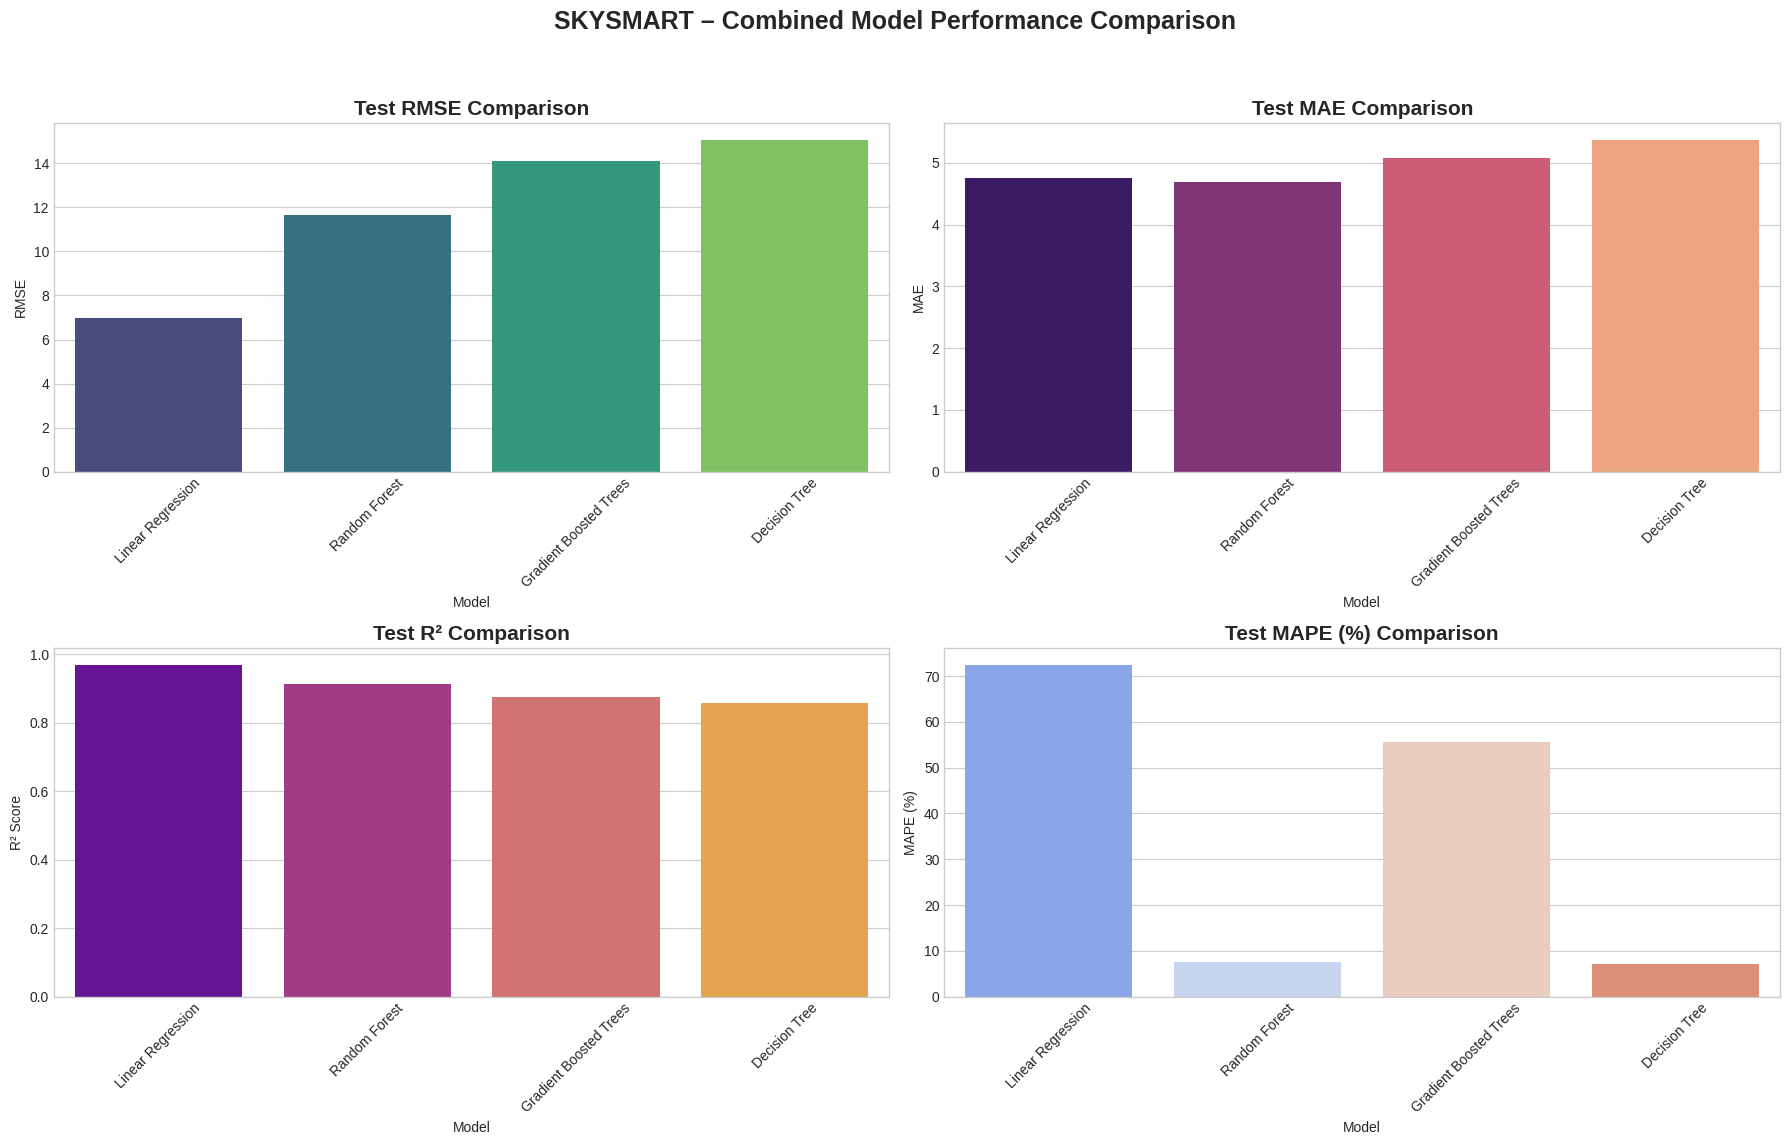

✔ Combined model comparison plot saved at: /kaggle/working/visualizations/combined_model_comparison.png


In [24]:
# ============================================================
# SKYSMART – FINAL MODEL COMPARISON TABLE (ONLY 4 MODELS)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("===========================================")
print(" SKYSMART – FINAL MODEL COMPARISON TABLE (4 MODELS)")
print("===========================================\n")

model_results = [
    {
        "Model": "Linear Regression",
        "Train RMSE": 7.1072,
        "Test RMSE": 6.9955,
        "Train MAE": 4.7260,
        "Test MAE": 4.7488,
        "Train R2": 0.9685,
        "Test R2": 0.9691,
        "Train MAPE (%)": 74.12,
        "Test MAPE (%)": 72.45,
    },
    {
        "Model": "Random Forest",
        "Train RMSE": 10.6461,
        "Test RMSE": 11.6713,
        "Train MAE": 4.5254,
        "Test MAE": 4.6979,
        "Train R2": 0.9292,
        "Test R2": 0.9141,
        "Train MAPE (%)": 7.26,
        "Test MAPE (%)": 7.62,
    },
    {
        "Model": "Gradient Boosted Trees",
        "Train RMSE": 13.9182,
        "Test RMSE": 14.0910,
        "Train MAE": 5.0305,
        "Test MAE": 5.0856,
        "Train R2": 0.8790,
        "Test R2": 0.8748,
        "Train MAPE (%)": 55.72,
        "Test MAPE (%)": 55.53,
    },
    {
        "Model": "Decision Tree",
        "Train RMSE": 14.4089,
        "Test RMSE": 15.0689,
        "Train MAE": 5.2674,
        "Test MAE": 5.3727,
        "Train R2": 0.8704,
        "Test R2": 0.8568,
        "Train MAPE (%)": 6.86,
        "Test MAPE (%)": 7.08,
    }
]

# Convert to DataFrame
comparison_df = pd.DataFrame(model_results)

print("\n📌 FINAL MODEL COMPARISON TABLE (4 MODELS)\n")
display(comparison_df)

# Save table
output_path = "/kaggle/working/reports/model_comparison_table_4models.csv"
comparison_df.to_csv(output_path, index=False)
print(f"\n✔ Model comparison table saved to: {output_path}")


# ============================================================
# Identify BEST MODEL (Lowest Test RMSE)
# ============================================================

best_model_row = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_model_name = best_model_row['Model']
best_model_rmse = best_model_row['Test RMSE']

print("\n===========================================")
print(" ⭐ BEST MODEL SELECTION")
print("===========================================\n")
print(f"Best Model : {best_model_name}")
print(f"Best Test RMSE : {best_model_rmse:.4f}")
print("\nReason: It has the LOWEST Test RMSE → Highest prediction accuracy.")
print("===========================================\n")


# ============================================================
# SKYSMART – COMBINED MODEL COMPARISON PLOTS (RMSE, MAE, R2, MAPE)
# ============================================================

save_path = "/kaggle/working/visualizations/"
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(18, 12))

# -----------------------------
# 1) RMSE Comparison
# -----------------------------
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Test RMSE', data=comparison_df, palette='viridis')
plt.title("Test RMSE Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("RMSE")

# -----------------------------
# 2) MAE Comparison
# -----------------------------
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Test MAE', data=comparison_df, palette='magma')
plt.title("Test MAE Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAE")

# -----------------------------
# 3) R² Comparison
# -----------------------------
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Test R2', data=comparison_df, palette='plasma')
plt.title("Test R² Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("R² Score")

# -----------------------------
# 4) MAPE Comparison
# -----------------------------
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Test MAPE (%)', data=comparison_df, palette='coolwarm')
plt.title("Test MAPE (%) Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAPE (%)")

plt.suptitle("SKYSMART – Combined Model Performance Comparison", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

output_file = save_path + "combined_model_comparison.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"✔ Combined model comparison plot saved at: {output_file}")


 SKYSMART – FINAL MODEL COMPARISON TABLE (3 MODELS)


📌 FINAL MODEL COMPARISON TABLE (3 MODELS)



,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2,Train MAPE (%),Test MAPE (%)
0,Linear Regression,7.1072,6.9955,4.7260,4.7488,0.9685,0.9691,74.12,72.45
1,Random Forest,10.6461,11.6713,4.5254,4.6979,0.9292,0.9141,7.26,7.62
2,Decision Tree,14.4089,15.0689,5.2674,5.3727,0.8704,0.8568,6.86,7.08



✔ Model comparison table saved to: /kaggle/working/reports/model_comparison_table_3models.csv

 ⭐ BEST MODEL SELECTION

Best Model : Linear Regression
Best Test RMSE : 6.9955

Reason: It has the LOWEST Test RMSE → Highest prediction accuracy.



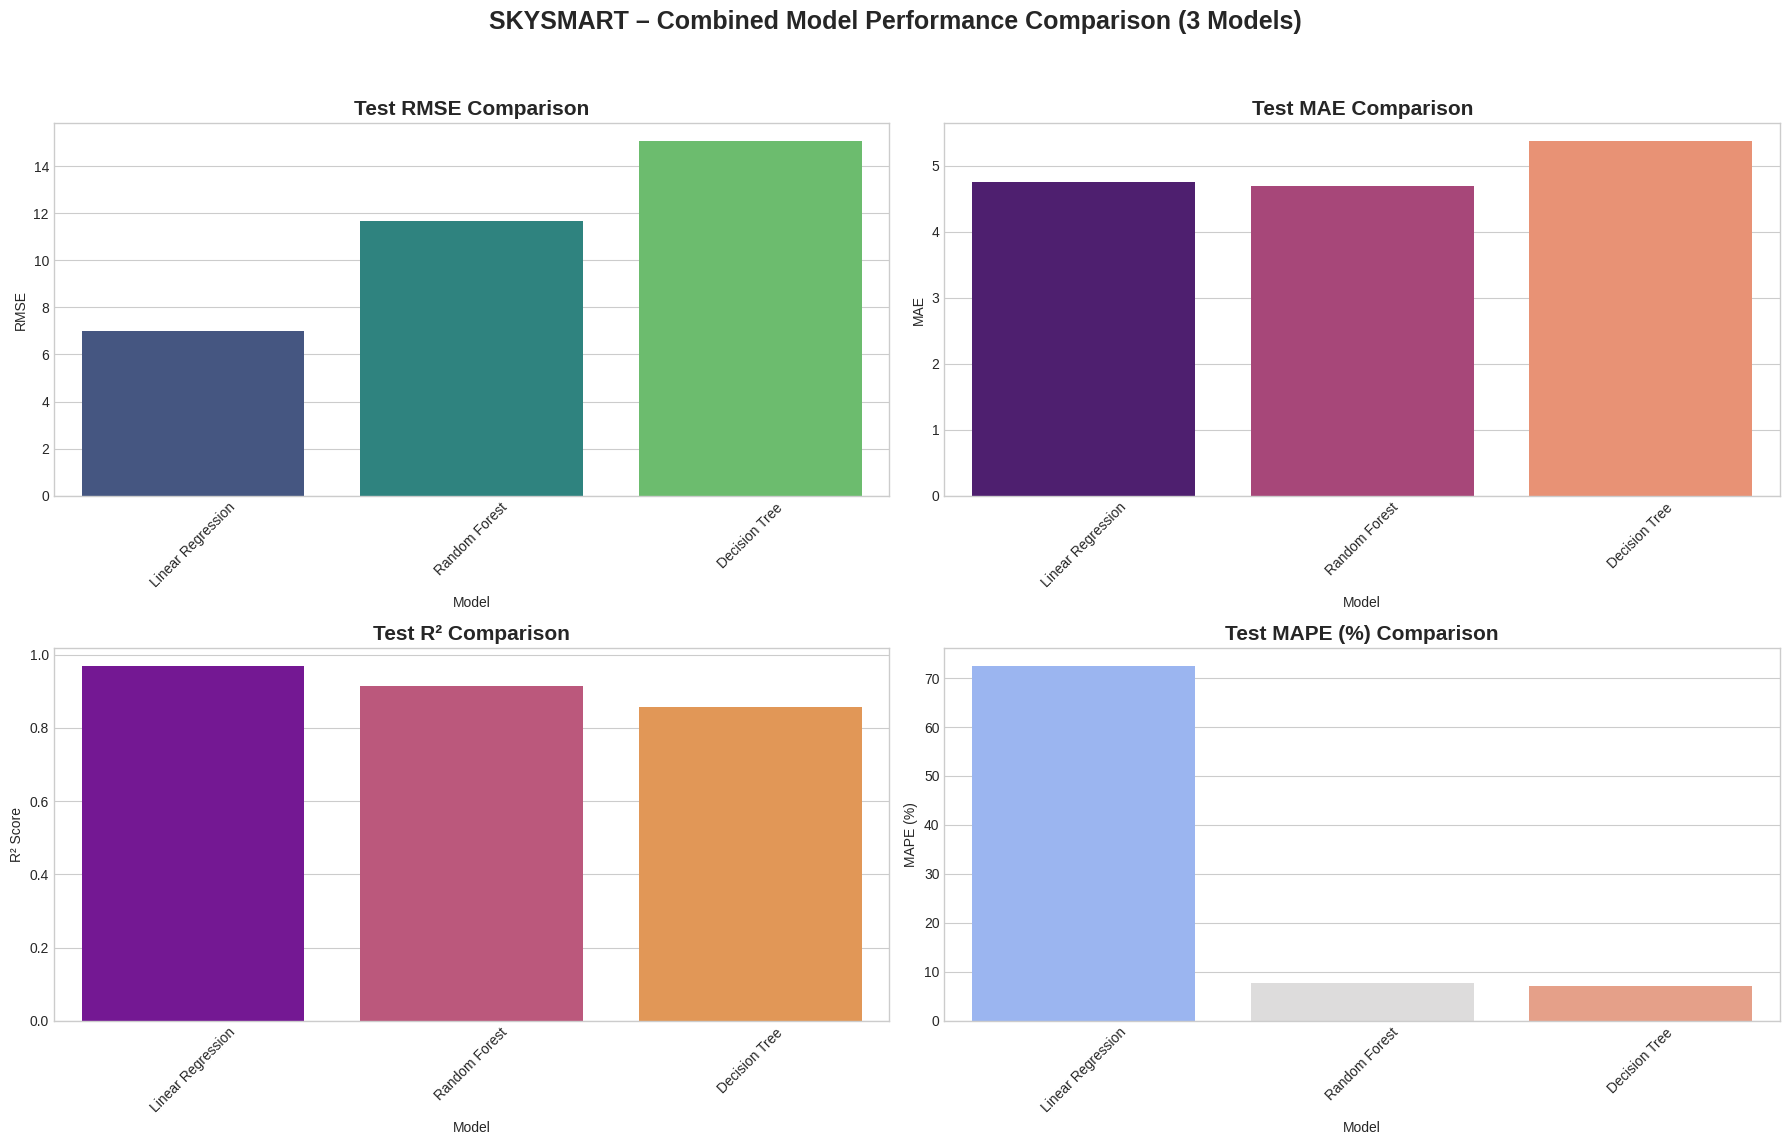

✔ Combined model comparison plot saved at: /kaggle/working/visualizations/combined_model_comparison_3models.png


25/11/23 16:54:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 16:55:00 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/11/23 16:55:45 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 16:55:55 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
25/11/23 16:56:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


In [30]:
# ============================================================
# SKYSMART – FINAL MODEL COMPARISON TABLE (ONLY 3 MODELS)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("===========================================")
print(" SKYSMART – FINAL MODEL COMPARISON TABLE (3 MODELS)")
print("===========================================\n")

model_results = [
    {
        "Model": "Linear Regression",
        "Train RMSE": 7.1072,
        "Test RMSE": 6.9955,
        "Train MAE": 4.7260,
        "Test MAE": 4.7488,
        "Train R2": 0.9685,
        "Test R2": 0.9691,
        "Train MAPE (%)": 74.12,
        "Test MAPE (%)": 72.45,
    },
    {
        "Model": "Random Forest",
        "Train RMSE": 10.6461,
        "Test RMSE": 11.6713,
        "Train MAE": 4.5254,
        "Test MAE": 4.6979,
        "Train R2": 0.9292,
        "Test R2": 0.9141,
        "Train MAPE (%)": 7.26,
        "Test MAPE (%)": 7.62,
    },
    {
        "Model": "Decision Tree",
        "Train RMSE": 14.4089,
        "Test RMSE": 15.0689,
        "Train MAE": 5.2674,
        "Test MAE": 5.3727,
        "Train R2": 0.8704,
        "Test R2": 0.8568,
        "Train MAPE (%)": 6.86,
        "Test MAPE (%)": 7.08,
    }
]

# Convert to DataFrame
comparison_df = pd.DataFrame(model_results)

print("\n📌 FINAL MODEL COMPARISON TABLE (3 MODELS)\n")
display(comparison_df)

# Save table
output_path = "/kaggle/working/reports/model_comparison_table_3models.csv"
comparison_df.to_csv(output_path, index=False)
print(f"\n✔ Model comparison table saved to: {output_path}")


# ============================================================
# Identify BEST MODEL (Lowest Test RMSE)
# ============================================================

best_model_row = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_model_name = best_model_row['Model']
best_model_rmse = best_model_row['Test RMSE']

print("\n===========================================")
print(" ⭐ BEST MODEL SELECTION")
print("===========================================\n")
print(f"Best Model : {best_model_name}")
print(f"Best Test RMSE : {best_model_rmse:.4f}")
print("\nReason: It has the LOWEST Test RMSE → Highest prediction accuracy.")
print("===========================================\n")


# ============================================================
# SKYSMART – COMBINED MODEL COMPARISON PLOTS (RMSE, MAE, R2, MAPE)
# ============================================================

save_path = "/kaggle/working/visualizations/"
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(18, 12))

# -----------------------------
# 1) RMSE Comparison
# -----------------------------
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Test RMSE', data=comparison_df, palette='viridis')
plt.title("Test RMSE Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("RMSE")

# -----------------------------
# 2) MAE Comparison
# -----------------------------
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Test MAE', data=comparison_df, palette='magma')
plt.title("Test MAE Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAE")

# -----------------------------
# 3) R² Comparison
# -----------------------------
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Test R2', data=comparison_df, palette='plasma')
plt.title("Test R² Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("R² Score")

# -----------------------------
# 4) MAPE Comparison
# -----------------------------
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Test MAPE (%)', data=comparison_df, palette='coolwarm')
plt.title("Test MAPE (%) Comparison", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAPE (%)")

plt.suptitle("SKYSMART – Combined Model Performance Comparison (3 Models)", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

output_file = save_path + "combined_model_comparison_3models.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"✔ Combined model comparison plot saved at: {output_file}")


In [26]:
# ============================================================
# MODEL 4 — DECISION TREE REGRESSOR (Hyperparameter Tuning)
# ============================================================

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs

print("\n===========================================")
print(" SKYSMART – HYPERPARAMETER TUNING : DECISION TREE")
print("===========================================\n")

# -------------------------------
# Base Model
# -------------------------------
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="arrival_delay"
)

# -------------------------------
# Parameter Grid (3 × 3 = 9 combos)
# -------------------------------
paramGrid = (
    ParamGridBuilder()
    .addGrid(dt.maxDepth, [6, 10, 14])
    .addGrid(dt.maxBins, [32, 64, 128])
    .build()
)

# -------------------------------
# Evaluator (RMSE)
# -------------------------------
evaluator = RegressionEvaluator(
    labelCol="arrival_delay",
    predictionCol="prediction",
    metricName="rmse"
)

# -------------------------------
# TrainValidationSplit (80/20)
# -------------------------------
tvs = TrainValidationSplit(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8
)

print("⏳ Running hyperparameter tuning... (Decision Tree)")
dt_tuned = tvs.fit(train_df)
best_dt = dt_tuned.bestModel

print("\n✔ Best Decision Tree Model Identified!")
print("----------------------------------------")
print(f" • maxDepth : {best_dt.getOrDefault('maxDepth')}")
print(f" • maxBins  : {best_dt.getOrDefault('maxBins')}")
print("----------------------------------------\n")

# ============================================================
# PREDICTIONS
# ============================================================
train_pred = best_dt.transform(train_df)
test_pred = best_dt.transform(test_df)

# ============================================================
# MAPE FUNCTION
# ============================================================
def compute_mape(df, label="arrival_delay"):
    return (
        df.select(
            (
                when(col(label) == 0,
                     spark_abs(col(label) - col("prediction")))
                .otherwise(spark_abs(col(label) - col("prediction")) / col(label))
            ).alias("mape")
        )
        .agg({"mape": "avg"})
        .collect()[0][0] * 100
    )

# ============================================================
# METRICS
# ============================================================

rmse_eval = evaluator
mae_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

train_rmse = rmse_eval.evaluate(train_pred)
test_rmse  = rmse_eval.evaluate(test_pred)
train_mae  = mae_eval.evaluate(train_pred)
test_mae   = mae_eval.evaluate(test_pred)
train_r2   = r2_eval.evaluate(train_pred)
test_r2    = r2_eval.evaluate(test_pred)
train_mape = compute_mape(train_pred)
test_mape  = compute_mape(test_pred)

# ============================================================
# FINAL PRINT — PROFESSIONAL FORMAT
# ============================================================
print("📊 DECISION TREE — FINAL TUNED METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Test MAE   : {test_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print(f"Test MAPE  : {test_mape:.2f}%")
print("----------------------------------------\n")

# ============================================================
# SAVE MODEL
# ============================================================
model_path = "/kaggle/working/models/dt_tuned"
best_dt.save(model_path)
print(f"✔ Tuned Decision Tree model saved at: {model_path}\n")



 SKYSMART – HYPERPARAMETER TUNING : DECISION TREE

⏳ Running hyperparameter tuning... (Decision Tree)


25/11/23 12:36:49 WARN CacheManager: Asked to cache already cached data.
25/11/23 12:36:50 WARN CacheManager: Asked to cache already cached data.
25/11/23 12:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
25/11/23 12:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1107.5 KiB
25/11/23 12:40:48 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
25/11/23 12:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1111.9 KiB
25/11/23 12:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1320.5 KiB
25/11/23 12:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1894.5 KiB
25/11/23 12:40:56 WARN DAGScheduler: Broadcasting large task binary with size 1878.8 KiB
25/11/23 12:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1545.4 KiB
25/11/23 12:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB
25/11/23 12:41:08 WARN DAGScheduler: Broadcasting lar


✔ Best Decision Tree Model Identified!
----------------------------------------
 • maxDepth : 10
 • maxBins  : 128
----------------------------------------



25/11/23 12:57:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/23 12:58:55 WARN DAGScheduler: Broadcasting large task binary with size 1090.7 KiB
25/11/23 12:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1542.7 KiB
25/11/23 13:00:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/23 13:00:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/11/23 13:01:09 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/11/23 13:01:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.9 KiB
25/11/23 13:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1679.2 KiB
25/11/23 13:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1524.2 KiB
25/11/23 13:03:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/23 13:03:50 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/11/23

📊 DECISION TREE — FINAL TUNED METRICS
----------------------------------------
Train RMSE : 9.6263
Test RMSE  : 10.1892
Train MAE  : 4.2133
Test MAE   : 4.3169
Train R²   : 0.9421
Test R²    : 0.9345
Train MAPE : 5.81%
Test MAPE  : 6.15%
----------------------------------------

✔ Tuned Decision Tree model saved at: /kaggle/working/models/dt_tuned



25/11/23 13:20:28 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/11/23 13:20:58 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/11/23 13:21:34 WARN DAGScheduler: Broadcasting large task binary with size 1737.2 KiB
25/11/23 13:21:39 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


In [27]:
# ============================================================
# MODEL 3 — LINEAR REGRESSION (Hyperparameter Tuning)
# ============================================================

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

print("\n===========================================")
print(" SKYSMART – HYPERPARAMETER TUNING : LINEAR REGRESSION")
print("===========================================\n")

# -------------------------------
# Base Model
# -------------------------------
lr = LinearRegression(
    featuresCol="features",
    labelCol="arrival_delay"
)

# -------------------------------
# Parameter Grid
# -------------------------------
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.0, 0.1, 0.3])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [50, 100, 150])
    .build()
)

# -------------------------------
# Evaluator
# -------------------------------
evaluator = RegressionEvaluator(
    labelCol="arrival_delay",
    predictionCol="prediction",
    metricName="rmse"
)

# -------------------------------
# TrainValidationSplit
# -------------------------------
tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8
)

print("⏳ Running hyperparameter tuning... (Linear Regression)")
lr_tuned = tvs.fit(train_df)
best_lr = lr_tuned.bestModel

print("\n✔ Best Linear Regression Model Found!")
print("----------------------------------------")
print(f" • regParam        = {best_lr._java_obj.getRegParam()}")
print(f" • elasticNetParam = {best_lr._java_obj.getElasticNetParam()}")
print(f" • maxIter         = {best_lr._java_obj.getMaxIter()}")
print("----------------------------------------\n")

# -------------------------------
# Predictions
# -------------------------------
train_pred = best_lr.transform(train_df)
test_pred = best_lr.transform(test_df)

# -------------------------------
# Metrics
# -------------------------------
train_rmse = evaluator.evaluate(train_pred)
test_rmse  = evaluator.evaluate(test_pred)

mae_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

train_mae = mae_eval.evaluate(train_pred)
test_mae  = mae_eval.evaluate(test_pred)
train_r2  = r2_eval.evaluate(train_pred)
test_r2   = r2_eval.evaluate(test_pred)

print("📊 LINEAR REGRESSION — FINAL TUNED METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test  RMSE : {test_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Test  MAE  : {test_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test  R²   : {test_r2:.4f}")
print("----------------------------------------\n")

best_lr.save("/kaggle/working/models/lr_tuned")
print("✔ Saved tuned Linear Regression model.\n")



 SKYSMART – HYPERPARAMETER TUNING : LINEAR REGRESSION

⏳ Running hyperparameter tuning... (Linear Regression)


25/11/23 13:22:26 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/23 13:22:42 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/11/23 13:24:16 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 13:24:29 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
25/11/23 13:25:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 13:25:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/23 13:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/23 13:25:18 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
25/11/23 13:25:40 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 13:25:56 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
25/11/23 13:26:25 WARN DAGScheduler: Broadcasting large task binary with s


✔ Best Linear Regression Model Found!
----------------------------------------
 • regParam        = 0.0
 • elasticNetParam = 0.0
 • maxIter         = 50
----------------------------------------



25/11/23 13:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1083.3 KiB
25/11/23 13:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1554.6 KiB
25/11/23 13:59:02 WARN DAGScheduler: Broadcasting large task binary with size 1089.6 KiB
25/11/23 14:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1559.7 KiB


📊 LINEAR REGRESSION — FINAL TUNED METRICS
----------------------------------------
Train RMSE : 7.1064
Test  RMSE : 6.9934
Train MAE  : 4.7245
Test  MAE  : 4.7471
Train R²   : 0.9685
Test  R²   : 0.9692
----------------------------------------



✔ Saved tuned Linear Regression model.



In [29]:
# ============================================================
# MODEL 1 — RANDOM FOREST REGRESSOR (FAST Hyperparameter Tuning)
# ============================================================

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs

print("\n===========================================")
print(" SKYSMART – FAST HYPERPARAMETER TUNING : RANDOM FOREST")
print("===========================================\n")

# -------------------------------
# Base Model
# -------------------------------
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    seed=42
)

# -------------------------------
# FAST Parameter Grid (6 combos)
# -------------------------------
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [6, 10])
    .addGrid(rf.maxBins, [32])      # fixed to reduce load
    .build()
)

# -------------------------------
# Evaluator
# -------------------------------
evaluator = RegressionEvaluator(
    labelCol="arrival_delay",
    predictionCol="prediction",
    metricName="rmse"
)

# -------------------------------
# TrainValidationSplit
# -------------------------------
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=2
)

print("⏳ Running FAST hyperparameter tuning... (Random Forest)")
rf_tuned = tvs.fit(train_df)
best_rf = rf_tuned.bestModel

print("\n✔ Best FAST Random Forest Model Found!")
print("----------------------------------------")
print(f" • numTrees = {best_rf.getNumTrees}")
print(f" • maxDepth = {best_rf.getOrDefault('maxDepth')}")
print(f" • maxBins  = {best_rf.getOrDefault('maxBins')}")
print("----------------------------------------\n")

# -------------------------------
# Predictions
# -------------------------------
train_pred = best_rf.transform(train_df)
test_pred = best_rf.transform(test_df)

# -------------------------------
# MAPE Function
# -------------------------------
def compute_mape(df, label="arrival_delay"):
    return (
        df.select(
            (
                when(col(label) == 0,
                     spark_abs(col(label) - col("prediction")))
                .otherwise(spark_abs(col(label) - col("prediction")) / col(label))
            ).alias("mape")
        )
        .agg({"mape": "avg"})
        .collect()[0][0] * 100
    )

# -------------------------------
# Metrics
# -------------------------------
rmse_eval = evaluator
mae_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

train_rmse = rmse_eval.evaluate(train_pred)
test_rmse  = rmse_eval.evaluate(test_pred)
train_mae  = mae_eval.evaluate(train_pred)
test_mae   = mae_eval.evaluate(test_pred)
train_r2   = r2_eval.evaluate(train_pred)
test_r2    = r2_eval.evaluate(test_pred)
train_mape = compute_mape(train_pred)
test_mape  = compute_mape(test_pred)

print("📊 RANDOM FOREST — FINAL FAST TUNED METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Test MAE   : {test_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print(f"Test MAPE  : {test_mape:.2f}%")
print("----------------------------------------\n")

best_rf.save("/kaggle/working/models/rf_tuned_fast")
print("✔ Saved FAST tuned Random Forest model.\n")



 SKYSMART – FAST HYPERPARAMETER TUNING : RANDOM FOREST

⏳ Running FAST hyperparameter tuning... (Random Forest)


25/11/23 15:08:54 WARN CacheManager: Asked to cache already cached data.
25/11/23 15:08:54 WARN CacheManager: Asked to cache already cached data.        
25/11/23 15:10:18 WARN DAGScheduler: Broadcasting large task binary with size 2030.8 KiB
25/11/23 15:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1100.2 KiB
25/11/23 15:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1100.2 KiB
25/11/23 15:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
25/11/23 15:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1545.5 KiB
25/11/23 15:11:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/23 15:12:18 WARN DAGScheduler: Broadcasting large task binary with size 2022.4 KiB
25/11/23 15:12:27 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/11/23 15:13:20 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
25/11/23 15:14:03 WARN DAGScheduler: Broadcasting larg


✔ Best FAST Random Forest Model Found!
----------------------------------------
 • numTrees = 100
 • maxDepth = 10
 • maxBins  = 32
----------------------------------------



25/11/23 15:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1299.1 KiB
25/11/23 15:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1305.9 KiB
25/11/23 15:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1319.7 KiB
25/11/23 15:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1324.1 KiB
25/11/23 15:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1324.5 KiB
25/11/23 15:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1325.1 KiB
25/11/23 15:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB
25/11/23 15:59:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/23 16:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1328.5 KiB
25/11/23 16:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
25/11/23 16:00:21 WARN DAGScheduler: Broadcasting large task binary with size 1341.7 KiB
25/11/23 16:00:22 WARN D

📊 RANDOM FOREST — FINAL FAST TUNED METRICS
----------------------------------------
Train RMSE : 14.3850
Test RMSE  : 14.6818
Train MAE  : 5.6812
Test MAE   : 5.7616
Train R²   : 0.8708
Test R²    : 0.8641
Train MAPE : 10.17%
Test MAPE  : 10.10%
----------------------------------------



25/11/23 16:41:02 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:02 WARN TaskSetManager: Stage 22741 contains a task of very large size (3049 KiB). The maximum recommended task size is 1000 KiB.
25/11/23 16:41:02 WARN DAGScheduler: Broadcasting large task binary with size 2017.7 KiB
25/11/23 16:41:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


✔ Saved FAST tuned Random Forest model.



25/11/23 16:41:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:07 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:07 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:18 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 16:41:19 WARN DAGScheduler: Broadcasting larg

In [ ]:
# ============================================================
# MODEL 2 — GRADIENT BOOSTED TREES (FAST Hyperparameter Tuning)
# ============================================================

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs

print("\n===========================================")
print(" SKYSMART – FAST HYPERPARAMETER TUNING : GBT")
print("===========================================\n")

# ---------------------------------
# Base Model
# ---------------------------------
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    seed=42
)

# ---------------------------------
# FAST Parameter Grid (Low runtime)
# ---------------------------------
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [4, 6])       # reduced from 3 → 2
    .addGrid(gbt.maxIter, [20, 40])      # reduced from 3 → 2
    .addGrid(gbt.stepSize, [0.05, 0.1])  # reduced from 3 → 2
    .build()
)
# Total combos = 2 × 2 × 2 = **8 only**

# ---------------------------------
# Evaluator
# ---------------------------------
evaluator = RegressionEvaluator(
    labelCol="arrival_delay",
    predictionCol="prediction",
    metricName="rmse"
)

# ---------------------------------
# TrainValidationSplit
# ---------------------------------
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=2          # 🚀 lowers broadcast size
)

print("⏳ Running FAST hyperparameter tuning... (GBT)")
gbt_tuned = tvs.fit(train_df)
best_gbt = gbt_tuned.bestModel

print("\n✔ Best FAST GBT Model Found!")
print("----------------------------------------")
print(f" • maxDepth = {best_gbt.getOrDefault('maxDepth')}")
print(f" • maxIter  = {best_gbt.getOrDefault('maxIter')}")
print(f" • stepSize = {best_gbt.getOrDefault('stepSize')}")
print("----------------------------------------\n")

# ---------------------------------
# Predictions
# ---------------------------------
train_pred = best_gbt.transform(train_df)
test_pred = best_gbt.transform(test_df)

# ---------------------------------
# MAPE Function
# ---------------------------------
def compute_mape(df, label="arrival_delay"):
    return (
        df.select(
            (
                when(col(label) == 0,
                     spark_abs(col(label) - col("prediction")))
                .otherwise(spark_abs(col(label) - col("prediction")) / col(label))
            ).alias("mape")
        )
        .agg({"mape": "avg"})
        .collect()[0][0] * 100
    )

# ---------------------------------
# Metrics
# ---------------------------------
rmse_eval = evaluator
mae_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

train_rmse = rmse_eval.evaluate(train_pred)
test_rmse  = rmse_eval.evaluate(test_pred)
train_mae  = mae_eval.evaluate(train_pred)
test_mae   = mae_eval.evaluate(test_pred)
train_r2   = r2_eval.evaluate(train_pred)
test_r2    = r2_eval.evaluate(test_pred)
train_mape = compute_mape(train_pred)
test_mape  = compute_mape(test_pred)

print("📊 FAST GBT — FINAL TUNED METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Test MAE   : {test_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print(f"Test MAPE  : {test_mape:.2f}%")
print("----------------------------------------\n")

# ---------------------------------
# Save Best Model
# ---------------------------------
best_gbt.save("/kaggle/working/models/gbt_fast_tuned")
print("✔ Saved FAST tuned GBT model.\n")


In [ ]:
# ============================================================
# MODEL 1 — RANDOM FOREST REGRESSOR (Hyperparameter Tuning)
# ============================================================

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, abs as spark_abs

print("\n===========================================")
print(" SKYSMART – HYPERPARAMETER TUNING : RANDOM FOREST")
print("===========================================\n")

# -------------------------------
# Base Model
# -------------------------------
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="arrival_delay",
    seed=42
)

# -------------------------------
# Parameter Grid (9 combinations)
# -------------------------------
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100, 150])
    .addGrid(rf.maxDepth, [6, 10, 14])
    .addGrid(rf.maxBins, [32, 64, 128])
    .build()
)

# -------------------------------
# Evaluator
# -------------------------------
evaluator = RegressionEvaluator(
    labelCol="arrival_delay",
    predictionCol="prediction",
    metricName="rmse"
)

# -------------------------------
# TrainValidationSplit
# -------------------------------
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=2
)

print("⏳ Running hyperparameter tuning... (Random Forest)")
rf_tuned = tvs.fit(train_df)
best_rf = rf_tuned.bestModel

print("\n✔ Best Random Forest Model Found!")
print("----------------------------------------")
print(f" • numTrees = {best_rf.getNumTrees}")
print(f" • maxDepth = {best_rf.getOrDefault('maxDepth')}")
print(f" • maxBins  = {best_rf.getOrDefault('maxBins')}")
print("----------------------------------------\n")

# -------------------------------
# Predictions
# -------------------------------
train_pred = best_rf.transform(train_df)
test_pred = best_rf.transform(test_df)

# -------------------------------
# MAPE Function
# -------------------------------
def compute_mape(df, label="arrival_delay"):
    return (
        df.select(
            (
                when(col(label) == 0,
                     spark_abs(col(label) - col("prediction")))
                .otherwise(spark_abs(col(label) - col("prediction")) / col(label))
            ).alias("mape")
        )
        .agg({"mape": "avg"})
        .collect()[0][0] * 100
    )

# -------------------------------
# Metrics
# -------------------------------
rmse_eval = evaluator
mae_eval = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
r2_eval  = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

train_rmse = rmse_eval.evaluate(train_pred)
test_rmse  = rmse_eval.evaluate(test_pred)
train_mae  = mae_eval.evaluate(train_pred)
test_mae   = mae_eval.evaluate(test_pred)
train_r2   = r2_eval.evaluate(train_pred)
test_r2    = r2_eval.evaluate(test_pred)
train_mape = compute_mape(train_pred)
test_mape  = compute_mape(test_pred)

print("📊 RANDOM FOREST — FINAL TUNED METRICS")
print("----------------------------------------")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test RMSE  : {test_rmse:.4f}")
print(f"Train MAE  : {train_mae:.4f}")
print(f"Test MAE   : {test_mae:.4f}")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test R²    : {test_r2:.4f}")
print(f"Train MAPE : {train_mape:.2f}%")
print(f"Test MAPE  : {test_mape:.2f}%")
print("----------------------------------------\n")

best_rf.save("/kaggle/working/models/rf_tuned")
print("✔ Saved tuned Random Forest model.\n")


 SKYSMART – FINAL MODEL COMPARISON (TUNED MODELS)


📌 FINAL MODEL COMPARISON TABLE (TUNED MODELS)



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2,Train MAPE (%),Test MAPE (%)
0,Linear Regression (Tuned),7.1064,6.9934,4.7245,4.7471,0.9685,0.9692,NaN,NaN
1,Random Forest (FAST Tuned),14.3850,14.6818,5.6812,5.7616,0.8708,0.8641,10.17,10.10
2,Decision Tree (Tuned),9.6263,10.1892,4.2133,4.3169,0.9421,0.9345,5.81,6.15



✔ Tuned model comparison table saved to: /kaggle/working/reports/tuned_model_comparison.csv

 ⭐ BEST MODEL SELECTION

Best Model : Linear Regression (Tuned)
Best Test RMSE : 6.9934

Reason: Lowest Test RMSE → Highest prediction accuracy.



25/11/23 16:56:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


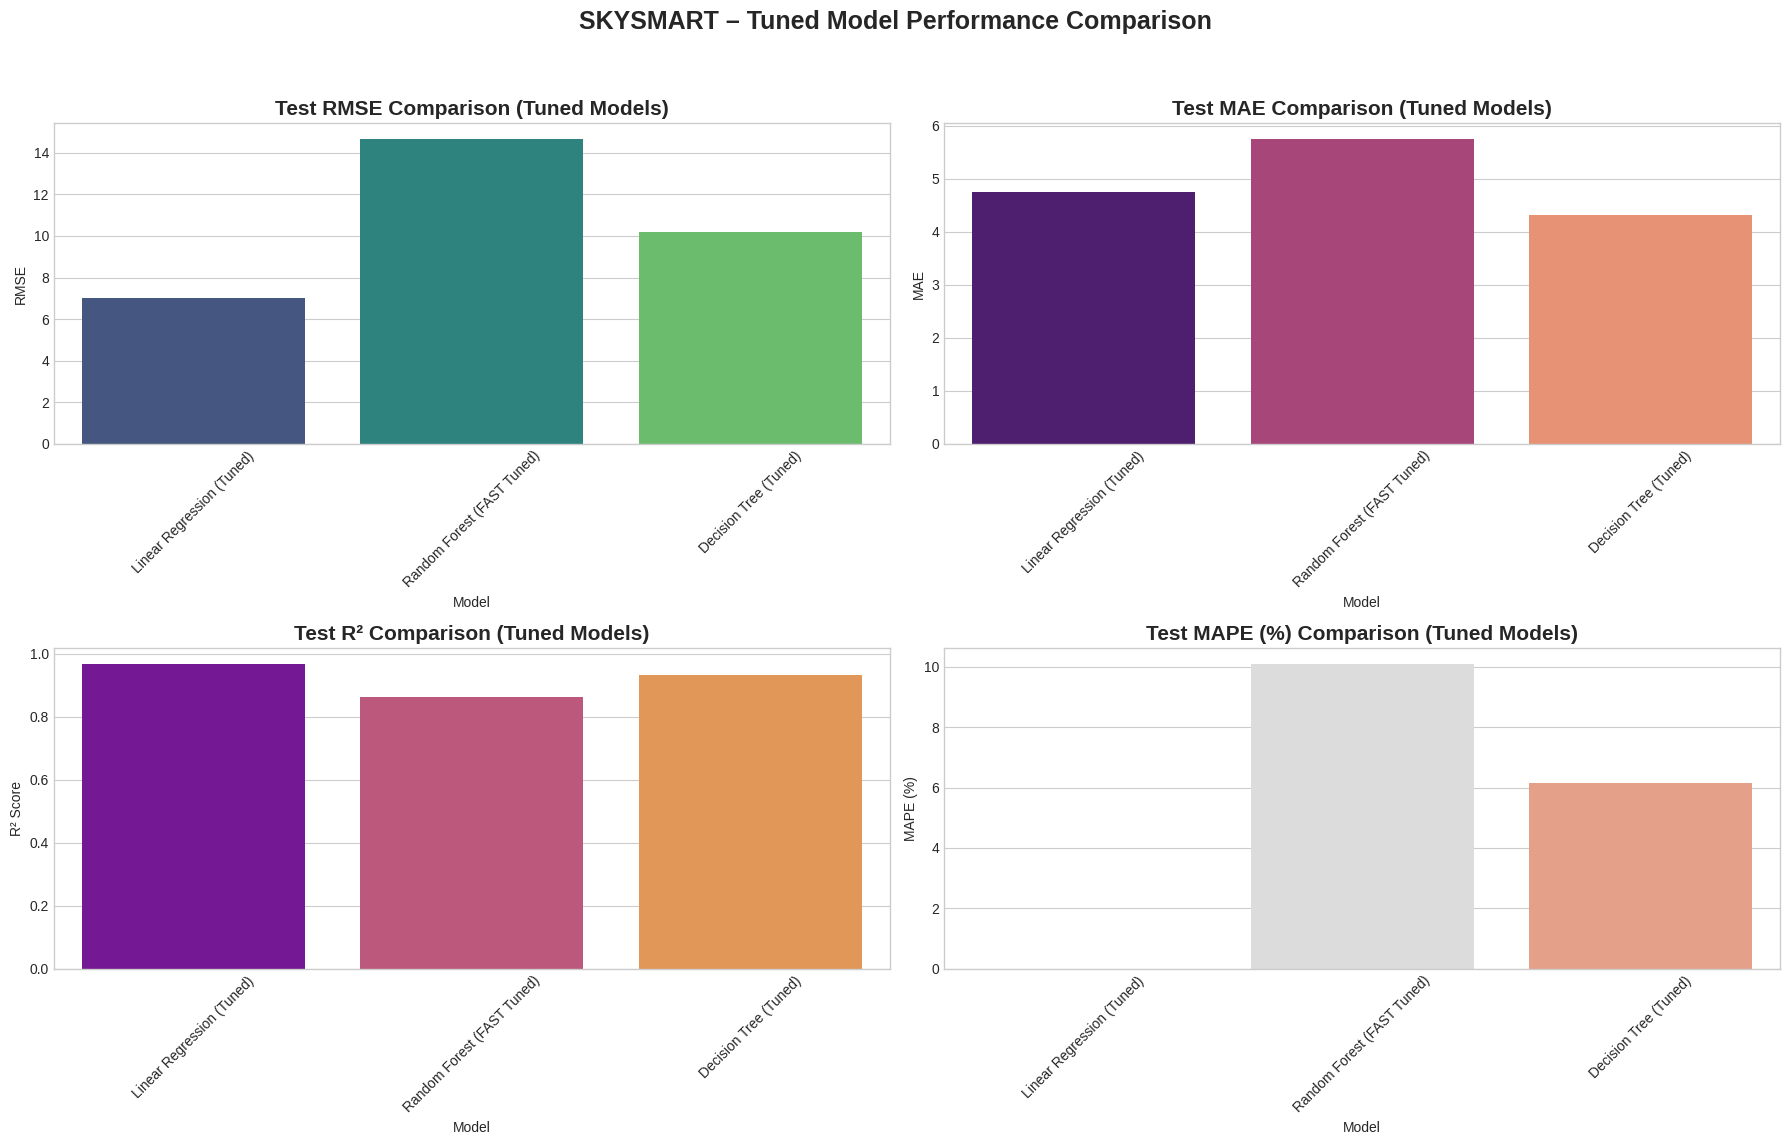

✔ Tuned model comparison plot saved at: /kaggle/working/visualizations/tuned_model_comparison.png


25/11/23 16:56:38 WARN DAGScheduler: Broadcasting large task binary with size 1317.4 KiB
25/11/23 16:56:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 16:57:05 WARN DAGScheduler: Broadcasting large task binary with size 20.3 MiB
25/11/23 16:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/23 16:57:38 WARN DAGScheduler: Broadcasting large task binary with size 2009.6 KiB
25/11/23 16:57:41 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
25/11/23 16:58:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/23 16:58:17 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
25/11/23 16:58:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 16:58:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/23 16:59:00 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
25/11/23 16:59:26 WARN DAGScheduler: Broadca

In [31]:
# ============================================================
# SKYSMART – FINAL MODEL COMPARISON (TUNED MODELS ONLY)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("===========================================")
print(" SKYSMART – FINAL MODEL COMPARISON (TUNED MODELS)")
print("===========================================\n")

# ------------------------------------------------------------
# TUNED MODEL RESULTS (Your actual tuned outputs)
# ------------------------------------------------------------
model_results = [
    {
        "Model": "Linear Regression (Tuned)",
        "Train RMSE": 7.1064,
        "Test RMSE": 6.9934,
        "Train MAE": 4.7245,
        "Test MAE": 4.7471,
        "Train R2": 0.9685,
        "Test R2": 0.9692,
        "Train MAPE (%)": None,
        "Test MAPE (%)": None,
    },
    {
        "Model": "Random Forest (FAST Tuned)",
        "Train RMSE": 14.3850,
        "Test RMSE": 14.6818,
        "Train MAE": 5.6812,
        "Test MAE": 5.7616,
        "Train R2": 0.8708,
        "Test R2": 0.8641,
        "Train MAPE (%)": 10.17,
        "Test MAPE (%)": 10.10,
    },
    {
        "Model": "Decision Tree (Tuned)",
        "Train RMSE": 9.6263,
        "Test RMSE": 10.1892,
        "Train MAE": 4.2133,
        "Test MAE": 4.3169,
        "Train R2": 0.9421,
        "Test R2": 0.9345,
        "Train MAPE (%)": 5.81,
        "Test MAPE (%)": 6.15,
    }
]

# Convert to DataFrame
comparison_df = pd.DataFrame(model_results)

print("\n📌 FINAL MODEL COMPARISON TABLE (TUNED MODELS)\n")
display(comparison_df)

# Save table
output_path = "/kaggle/working/reports/tuned_model_comparison.csv"
comparison_df.to_csv(output_path, index=False)
print(f"\n✔ Tuned model comparison table saved to: {output_path}")


# ============================================================
# Identify BEST MODEL (Lowest Test RMSE)
# ============================================================

best_model_row = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_model_name = best_model_row['Model']
best_model_rmse = best_model_row['Test RMSE']

print("\n===========================================")
print(" ⭐ BEST MODEL SELECTION")
print("===========================================\n")
print(f"Best Model : {best_model_name}")
print(f"Best Test RMSE : {best_model_rmse:.4f}")
print("\nReason: Lowest Test RMSE → Highest prediction accuracy.")
print("===========================================\n")


# ============================================================
# SKYSMART – COMBINED PERFORMANCE VISUALIZATIONS
# ============================================================

save_path = "/kaggle/working/visualizations/"
os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(18, 12))

# -----------------------------
# 1) RMSE Comparison
# -----------------------------
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Test RMSE', data=comparison_df, palette='viridis')
plt.title("Test RMSE Comparison (Tuned Models)", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("RMSE")

# -----------------------------
# 2) MAE Comparison
# -----------------------------
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Test MAE', data=comparison_df, palette='magma')
plt.title("Test MAE Comparison (Tuned Models)", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAE")

# -----------------------------
# 3) R² Comparison
# -----------------------------
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Test R2', data=comparison_df, palette='plasma')
plt.title("Test R² Comparison (Tuned Models)", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("R² Score")

# -----------------------------
# 4) MAPE Comparison
# -----------------------------
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Test MAPE (%)', data=comparison_df, palette='coolwarm')
plt.title("Test MAPE (%) Comparison (Tuned Models)", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("MAPE (%)")

plt.suptitle("SKYSMART – Tuned Model Performance Comparison", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

output_file = save_path + "tuned_model_comparison.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"✔ Tuned model comparison plot saved at: {output_file}")


In [32]:
import shutil

# Path of your best model
model_path = "/kaggle/working/models/lr_tuned"

# Output zip path
zip_path = "/kaggle/working/lr_tuned.zip"

# Create ZIP
shutil.make_archive("/kaggle/working/lr_tuned", 'zip', model_path)

zip_path


'/kaggle/working/lr_tuned.zip'

25/11/23 17:01:16 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
25/11/23 17:01:55 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 17:02:04 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB
25/11/23 17:02:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/23 17:02:37 WARN DAGScheduler: Broadcasting large task binary with size 1532.6 KiB
25/11/23 17:02:41 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
25/11/23 17:02:44 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
25/11/23 17:03:01 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 17:03:12 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
25/11/23 17:03:47 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 17:03:59 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
25/11/23 17:04:21 WARN DAGScheduler: Broadcast

In [33]:
hourly_congestion = flights.groupBy("dep_hour").count().orderBy("dep_hour")
hourly_congestion_df = hourly_congestion.toPandas()
hourly_congestion_df.to_csv("/kaggle/working/hourly_congestion.csv", index=False)
hourly_congestion_df.head()


,dep_hour,count
0,0,1698
1,1,1150
2,2,275
3,3,81
4,4,183


In [35]:
daily_congestion = flights.groupBy("day_of_week").count().orderBy("day_of_week")
daily_congestion_df = daily_congestion.toPandas()
daily_congestion_df.to_csv("/kaggle/working/daily_congestion.csv", index=False)
daily_congestion_df.head()


,day_of_week,count
0,1,145159
1,2,139148
2,3,141753
3,4,159800
4,5,163070


In [37]:
route_congestion = flights.groupBy("origin_airport", "destination_airport").count()

route_congestion_df = route_congestion.toPandas()
route_congestion_df.to_csv("/kaggle/working/route_congestion.csv", index=False)

route_congestion_df.head()


,origin_airport,destination_airport,count
0,ANC,SEA,983
1,LAX,PBI,38
2,SFO,CLT,308
3,LAX,MIA,574
4,SEA,ANC,979


In [38]:
df_fe.write.mode("overwrite").parquet("/kaggle/working/df_fe.parquet")
